170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Initial parameters check:
T = 0.01, Nt = 20
Calculated dt = T/Nt = 0.01/20 = 0.0005

Testing image: automobile

Processing case: SCALAR - α, β = constant
  α = 0.001000
  β = 0.001000

Processing case: VECTOR - α(y), β(x) = 1D arrays
  α range: [0.000501, 0.001499]
  β range: [0.000503, 0.001500]

Processing case: MATRIX - α(x,y), β(x,y) = 2D spatial arrays
  α range: [0.000700, 0.001300]
  β range: [0.000700, 0.001300]

Processing case: FUNCTION - α(t,y), β(t,x) = time-dependent functions
  α(t=0.005, y=0.25) = 0.001325
  β(t=0.005, x=0.0) = 0.001316


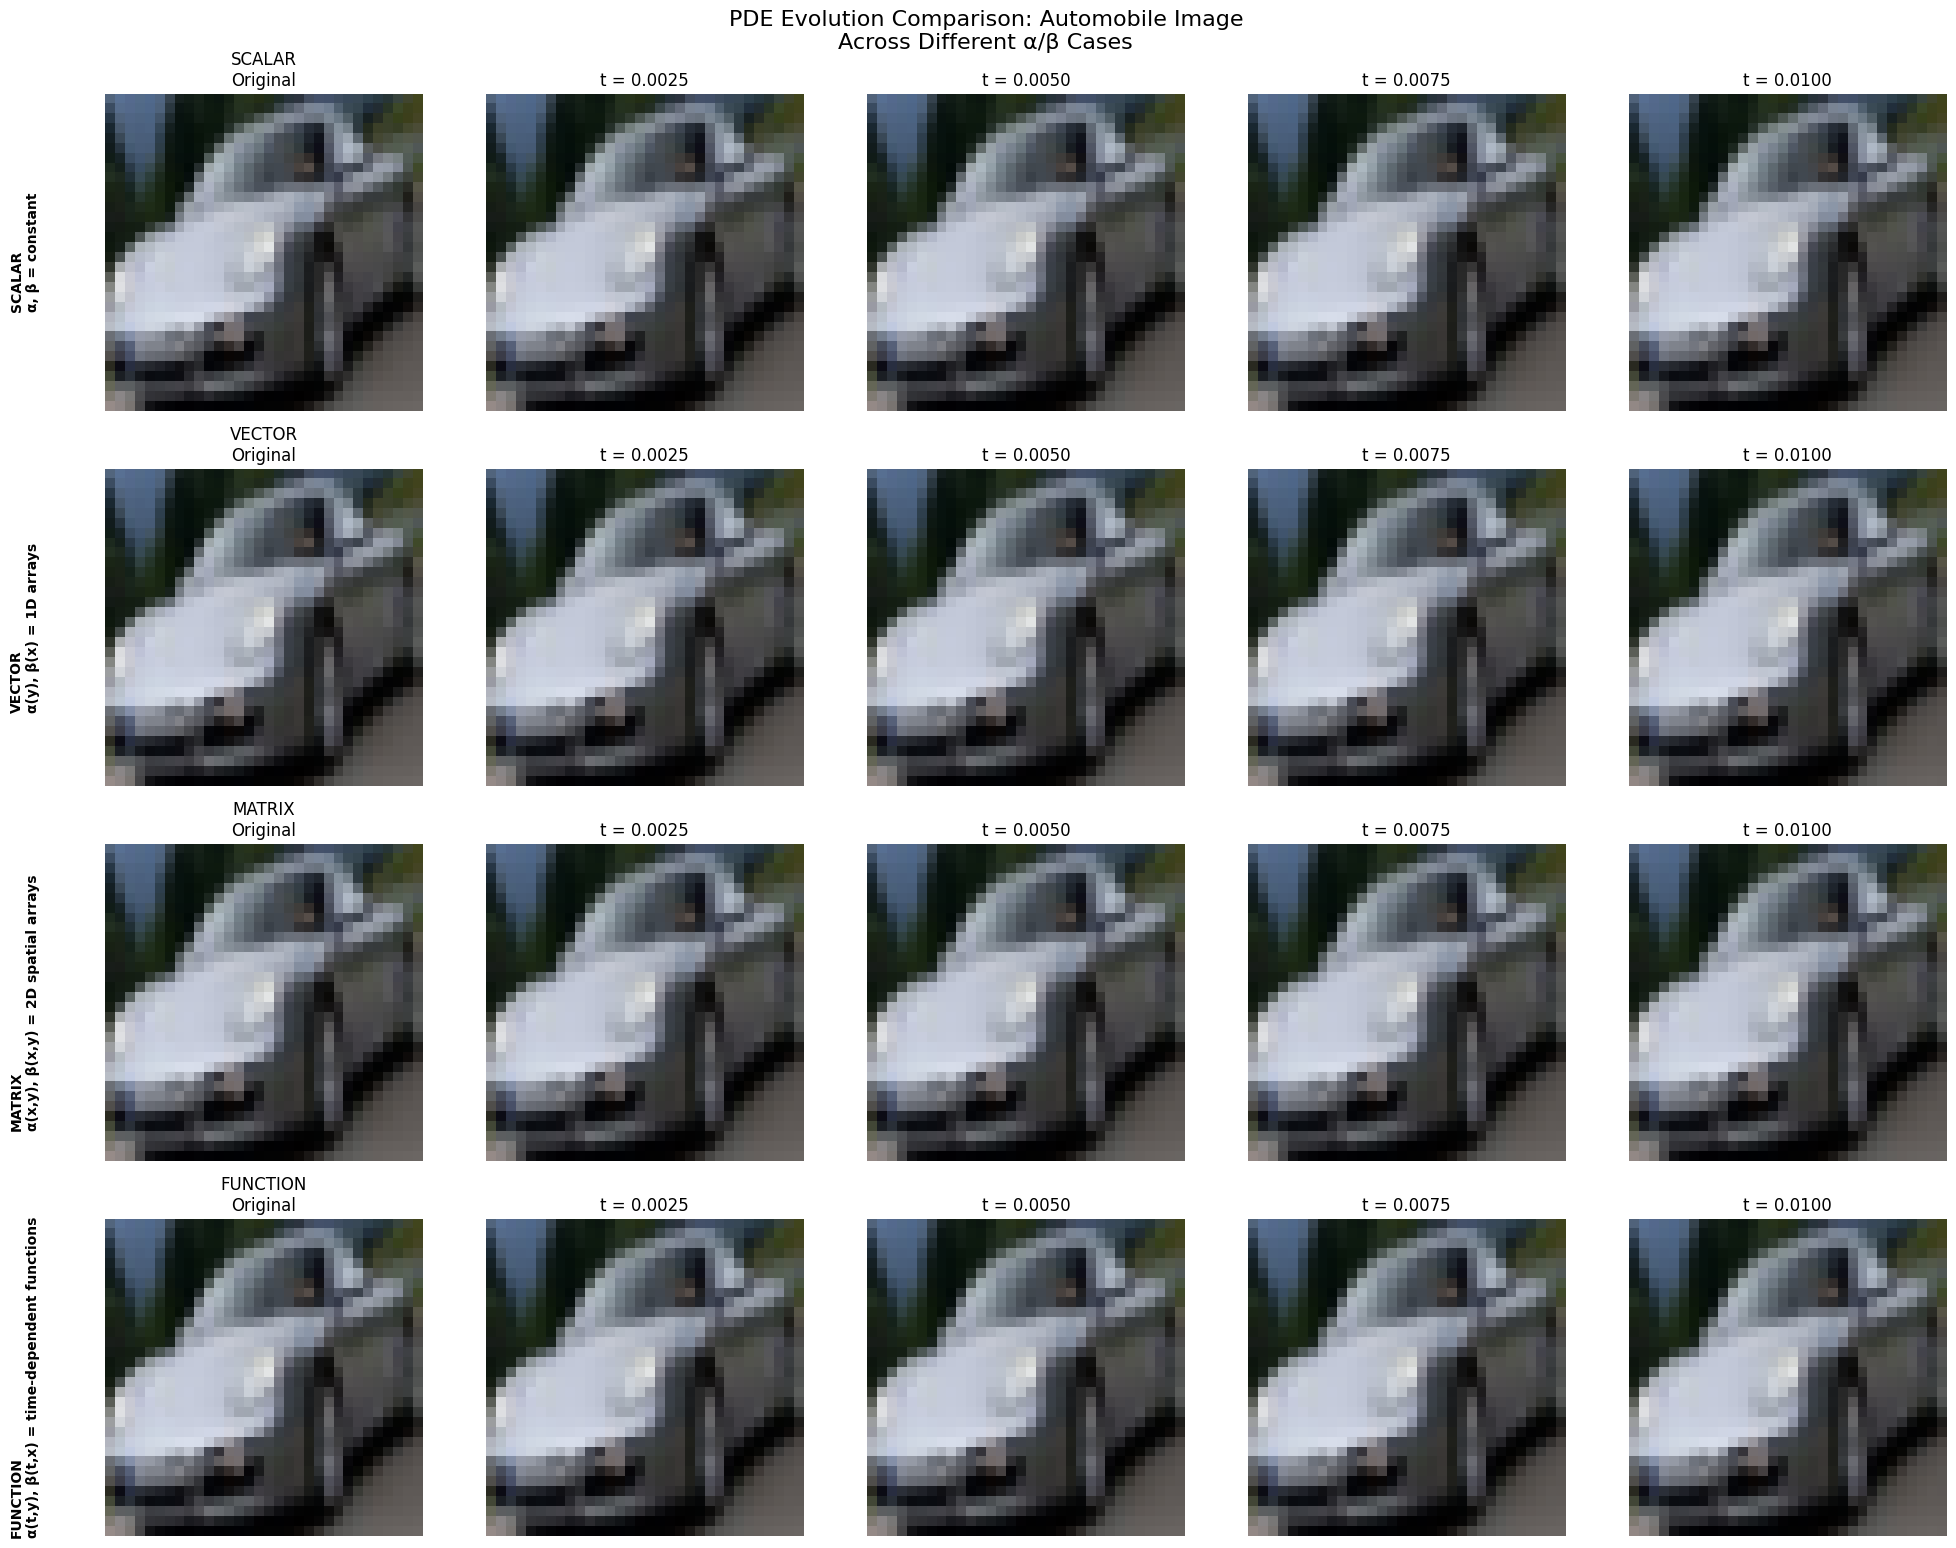

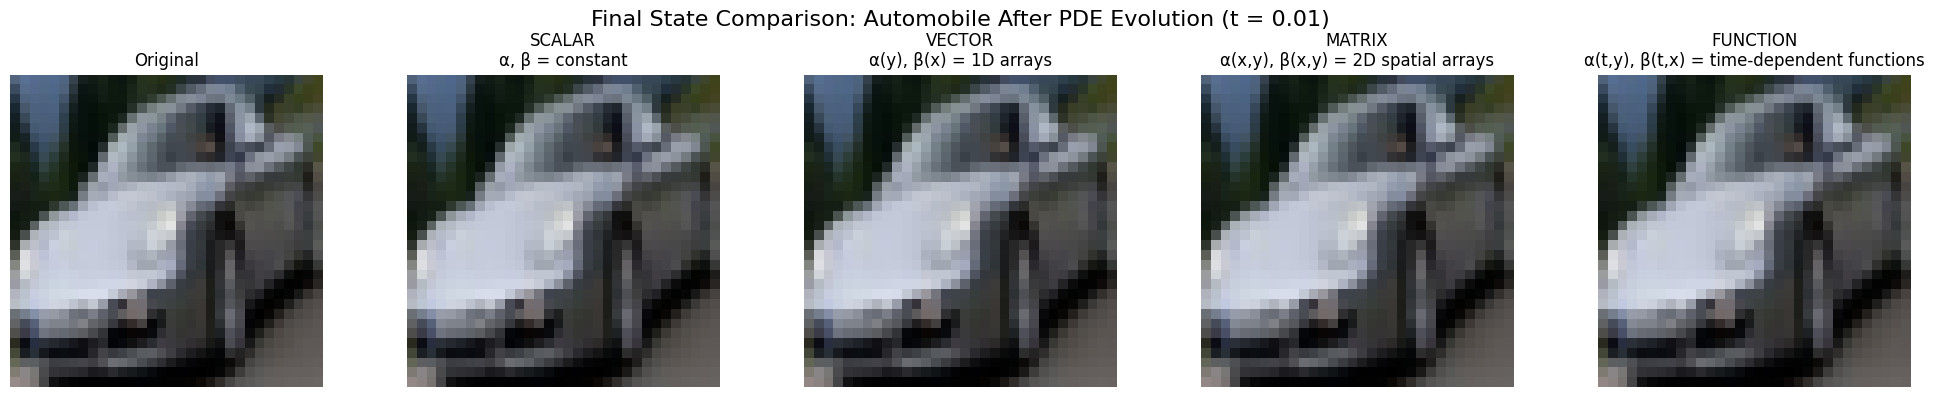


QUANTITATIVE ANALYSIS

Energy Analysis (original energy = 36856711.00):
--------------------------------------------------
SCALAR  : Final energy = 36453810.00, Ratio = 0.9891
VECTOR  : Final energy = 36454476.00, Ratio = 0.9891
MATRIX  : Final energy = 36453802.00, Ratio = 0.9891
FUNCTION: Final energy = 36454725.00, Ratio = 0.9891

Statistical Analysis:
--------------------------------------------------
Case     Mean     Std      ΔMean    ΔStd    
----------------------------------------
Original 90.02    62.40    --       --      
SCALAR   89.45    62.17    -0.57    -0.23   
VECTOR   89.46    62.16    -0.56    -0.24   
MATRIX   89.45    62.17    -0.57    -0.23   
FUNCTION 89.46    62.16    -0.56    -0.24   


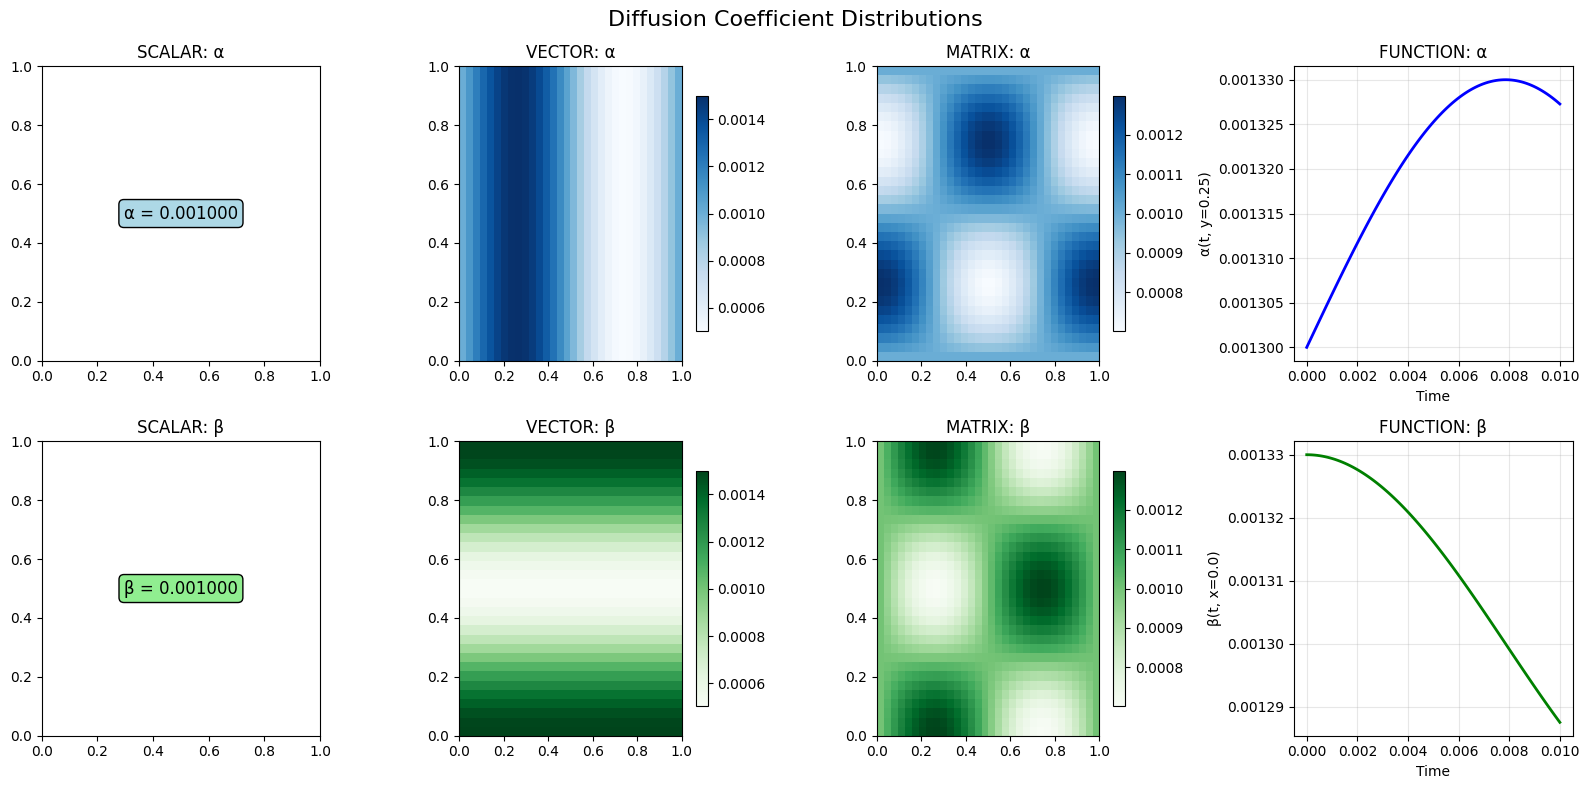


SUMMARY
• SCALAR: Uniform diffusion - symmetric smoothing
• VECTOR: 1D spatial variation - directional diffusion
• MATRIX: 2D spatial variation - both α(x,y) and β(x,y) depend on both coordinates
• FUNCTION: Time-dependent - dynamic diffusion behavior

All cases demonstrate different aspects of the diffusion process
and how coefficient structure affects image evolution patterns.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Parameters adapted for CIFAR-10 (32x32 images)
Lx, Ly = 1.0, 1.0
Nx, Ny = 32, 32  # CIFAR-10 image dimensions
T = 0.01  # Shorter time to preserve some image structure
Nt = 20   # Fewer time steps

dx = Lx / (Nx - 1)
dy = Ly / (Ny - 1)
dt = T / Nt

print(f"Initial parameters check:")
print(f"T = {T}, Nt = {Nt}")
print(f"Calculated dt = T/Nt = {T}/{Nt} = {dt}")
print()

x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)
X, Y = np.meshgrid(x, y, indexing='ij')

# Define the four cases for alpha and beta
class DiffusionCoefficients:
    def __init__(self, case_type):
        self.case_type = case_type
        self.setup_coefficients()

    def setup_coefficients(self):
        if self.case_type == "scalar":
            # Case 1: Scalar (constant values)
            self.alpha_val = 0.001
            self.beta_val = 0.001

        elif self.case_type == "vector":
            # Case 2: Vector (1D arrays)
            self.alpha_val = 0.001 + 0.0005 * np.sin(2 * np.pi * y)  # varies with y
            self.beta_val = 0.001 + 0.0005 * np.cos(2 * np.pi * x)   # varies with x

        elif self.case_type == "matrix":
            # Case 3: Matrix (2D spatial arrays)
            # Both alpha and beta depend on both x and y coordinates (but not time)
            self.alpha_val = 0.001 + 0.0003 * np.sin(2 * np.pi * Y) * np.cos(2 * np.pi * X)
            self.beta_val = 0.001 + 0.0003 * np.cos(2 * np.pi * Y) * np.sin(2 * np.pi * X)

        elif self.case_type == "function":
            # Case 4: Function (time-dependent)
            # These will be handled in get_alpha and get_beta methods
            pass

    def get_alpha(self, t, y_coord, j=None):
        if self.case_type == "scalar":
            return self.alpha_val
        elif self.case_type == "vector":
            if j is not None:
                return self.alpha_val[j]
            else:
                return 0.001 + 0.0005 * np.sin(2 * np.pi * y_coord)
        elif self.case_type == "matrix":
            # Alpha depends on (x, y): α(x,y) - 2D spatial array
            if j is not None:
                # Return alpha values for all x at y-coordinate j
                return self.alpha_val[:, j]
            else:
                # Return full matrix
                return self.alpha_val
        elif self.case_type == "function":
            return 0.001 + 0.0003 * np.sin(2 * np.pi * y_coord) * (1 + 0.1 * np.sin(200 * t))

    def get_beta(self, t, x_coord, i=None):
        if self.case_type == "scalar":
            return self.beta_val
        elif self.case_type == "vector":
            if i is not None:
                return self.beta_val[i]
            else:
                return 0.001 + 0.0005 * np.cos(2 * np.pi * x_coord)
        elif self.case_type == "matrix":
            # Beta depends on (x, y): β(x,y) - 2D spatial array
            if i is not None:
                # Return beta values for all y at x-coordinate i
                return self.beta_val[i, :]
            else:
                # Return full matrix
                return self.beta_val
        elif self.case_type == "function":
            return 0.001 + 0.0003 * np.cos(2 * np.pi * x_coord) * (1 + 0.1 * np.cos(200 * t))

# Thomas algorithm for tridiagonal system
def thomas(a, b, c, d):
    n = len(d)
    c_ = np.zeros(n-1)
    d_ = np.zeros(n)

    # Handle edge case
    if n == 1:
        return d / b

    c_[0] = c[0] / b[0]
    d_[0] = d[0] / b[0]

    for i in range(1, n-1):
        denom = b[i] - a[i-1] * c_[i-1]
        c_[i] = c[i] / denom
        d_[i] = (d[i] - a[i-1] * d_[i-1]) / denom

    d_[-1] = (d[-1] - a[-2] * d_[-2]) / (b[-1] - a[-2] * c_[-2])

    x_out = np.zeros(n)
    x_out[-1] = d_[-1]
    for i in reversed(range(n-1)):
        x_out[i] = d_[i] - c_[i] * x_out[i+1]

    return x_out

# Function to solve PDE for a single channel with different coefficient cases
def solve_pde_channel(initial_condition, diffusion_coeffs):
    # Normalize to [0, 1]
    u = initial_condition.astype(np.float64) / 255.0

    # Store evolution for visualization
    save_steps = [5, 10, 15, Nt]
    evolution = [(0.0, u.copy())]

    # Time stepping using Strang splitting
    for n in range(Nt):
        t = n * dt
        u_half = np.copy(u)

        # Step 1: half-step in x
        for j in range(Ny):
            if diffusion_coeffs.case_type in ["scalar", "function"]:
                alpha_val = diffusion_coeffs.get_alpha(t, y[j])
                a_x = -0.5 * dt * alpha_val / dx**2
            elif diffusion_coeffs.case_type == "vector":
                alpha_val = diffusion_coeffs.get_alpha(t, y[j], j)
                a_x = -0.5 * dt * alpha_val / dx**2
            elif diffusion_coeffs.case_type == "matrix":
                # For matrix case: alpha depends on (x, y) - varies across x for this y
                alpha_vals = diffusion_coeffs.get_alpha(t, y[j], j)
                # Use average for tridiagonal system approximation
                alpha_val = np.mean(alpha_vals)
                a_x = -0.5 * dt * alpha_val / dx**2

            b_x = 1 - 2 * a_x
            A = np.full(Nx-1, a_x)
            B = np.full(Nx, b_x)
            C = np.full(Nx-1, a_x)
            u_half[:, j] = thomas(A, B, C, u[:, j])

        u_temp = np.copy(u_half)

        # Step 2: full-step in y
        for i in range(Nx):
            if diffusion_coeffs.case_type in ["scalar", "function"]:
                beta_val = diffusion_coeffs.get_beta(t + 0.5*dt, x[i])
                b_y = -dt * beta_val / dy**2
            elif diffusion_coeffs.case_type == "vector":
                beta_val = diffusion_coeffs.get_beta(t + 0.5*dt, x[i], i)
                b_y = -dt * beta_val / dy**2
            elif diffusion_coeffs.case_type == "matrix":
                # For matrix case: beta depends on (x, y) - varies across y for this x
                beta_vals = diffusion_coeffs.get_beta(t + 0.5*dt, x[i], i)
                # Use average for tridiagonal system approximation
                beta_val = np.mean(beta_vals)
                b_y = -dt * beta_val / dy**2

            c_y = 1 - 2 * b_y
            A = np.full(Ny-1, b_y)
            B = np.full(Ny, c_y)
            C = np.full(Ny-1, b_y)
            u_temp[i, :] = thomas(A, B, C, u_half[i, :])

        u_half2 = np.copy(u_temp)

        # Step 3: another half-step in x
        for j in range(Ny):
            if diffusion_coeffs.case_type in ["scalar", "function"]:
                alpha_val = diffusion_coeffs.get_alpha(t + dt, y[j])
                a_x = -0.5 * dt * alpha_val / dx**2
            elif diffusion_coeffs.case_type == "vector":
                alpha_val = diffusion_coeffs.get_alpha(t + dt, y[j], j)
                a_x = -0.5 * dt * alpha_val / dx**2
            elif diffusion_coeffs.case_type == "matrix":
                # For matrix case: alpha depends on (x, y) - varies across x for this y
                alpha_vals = diffusion_coeffs.get_alpha(t + dt, y[j], j)
                # Use average for tridiagonal system approximation
                alpha_val = np.mean(alpha_vals)
                a_x = -0.5 * dt * alpha_val / dx**2

            b_x = 1 - 2 * a_x
            A = np.full(Nx-1, a_x)
            B = np.full(Nx, b_x)
            C = np.full(Nx-1, a_x)
            u_half2[:, j] = thomas(A, B, C, u_temp[:, j])

        u = u_half2

        # Store at specific steps
        step_number = n + 1
        if step_number in save_steps:
            current_time = step_number * dt
            evolution.append((current_time, u.copy()))

    return u, evolution

# Function to process RGB image with different coefficient cases
def solve_pde_rgb(rgb_image, diffusion_coeffs):
    results = []
    evolutions = []

    for channel in range(3):
        result, evolution = solve_pde_channel(rgb_image[:, :, channel], diffusion_coeffs)
        results.append(result)
        evolutions.append(evolution)

    # Combine channels for final result
    final_rgb = np.stack(results, axis=2)
    final_rgb = np.clip(final_rgb * 255, 0, 255).astype(np.uint8)

    return final_rgb, evolutions

# Test all four cases
cases = ["scalar", "vector", "matrix", "function"]
case_descriptions = {
    "scalar": "α, β = constant",
    "vector": "α(y), β(x) = 1D arrays",
    "matrix": "α(x,y), β(x,y) = 2D spatial arrays",
    "function": "α(t,y), β(t,x) = time-dependent functions"
}

# Select one CIFAR-10 image for comparison
np.random.seed(55)
test_image_idx = np.random.choice(len(x_test))
test_image = x_test[test_image_idx]
test_label = class_names[y_test[test_image_idx][0]]

print(f"Testing image: {test_label}")
print("=" * 50)

# Store results for all cases
results = {}
final_images = {}

# Process each case
for case in cases:
    print(f"\nProcessing case: {case.upper()} - {case_descriptions[case]}")
    diffusion_coeffs = DiffusionCoefficients(case)

    final_image, evolutions = solve_pde_rgb(test_image, diffusion_coeffs)
    results[case] = evolutions
    final_images[case] = final_image

    # Print coefficient statistics
    if case == "scalar":
        print(f"  α = {diffusion_coeffs.alpha_val:.6f}")
        print(f"  β = {diffusion_coeffs.beta_val:.6f}")
    elif case == "vector":
        print(f"  α range: [{np.min(diffusion_coeffs.alpha_val):.6f}, {np.max(diffusion_coeffs.alpha_val):.6f}]")
        print(f"  β range: [{np.min(diffusion_coeffs.beta_val):.6f}, {np.max(diffusion_coeffs.beta_val):.6f}]")
    elif case == "matrix":
        print(f"  α range: [{np.min(diffusion_coeffs.alpha_val):.6f}, {np.max(diffusion_coeffs.alpha_val):.6f}]")
        print(f"  β range: [{np.min(diffusion_coeffs.beta_val):.6f}, {np.max(diffusion_coeffs.beta_val):.6f}]")
    elif case == "function":
        # Sample function values at coordinates where spatial terms are non-zero
        t_sample, y_sample, x_sample = 0.005, 0.25, 0.0
        alpha_sample = diffusion_coeffs.get_alpha(t_sample, y_sample)
        beta_sample = diffusion_coeffs.get_beta(t_sample, x_sample)
        print(f"  α(t={t_sample}, y={y_sample}) = {alpha_sample:.6f}")
        print(f"  β(t={t_sample}, x={x_sample}) = {beta_sample:.6f}")

# Visualization: Evolution comparison across cases
fig, axes = plt.subplots(4, 5, figsize=(20, 16))
fig.suptitle(f'PDE Evolution Comparison: {test_label.title()} Image\nAcross Different α/β Cases', fontsize=16)

for row, case in enumerate(cases):
    # Original image
    axes[row, 0].imshow(test_image)
    axes[row, 0].set_title(f'{case.upper()}\nOriginal')
    axes[row, 0].axis('off')

    # Evolution steps
    evolutions = results[case]
    for step_idx in range(1, 5):
        if step_idx < len(evolutions[0]):
            time_val, _ = evolutions[0][step_idx]

            rgb_step = np.zeros((32, 32, 3))
            for c in range(3):
                if step_idx < len(evolutions[c]):
                    _, img_data = evolutions[c][step_idx]
                    rgb_step[:, :, c] = img_data

            rgb_step = np.clip(rgb_step * 255, 0, 255).astype(np.uint8)

            axes[row, step_idx].imshow(rgb_step)
            axes[row, step_idx].set_title(f't = {time_val:.4f}')
            axes[row, step_idx].axis('off')
        else:
            axes[row, step_idx].axis('off')

# Add case descriptions on the left
for row, case in enumerate(cases):
    axes[row, 0].text(-0.3, 0.5, f'{case.upper()}\n{case_descriptions[case]}',
                     transform=axes[row, 0].transAxes,
                     rotation=90, verticalalignment='center',
                     fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Final comparison visualization
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
fig.suptitle(f'Final State Comparison: {test_label.title()} After PDE Evolution (t = {T})', fontsize=16)

axes[0].imshow(test_image)
axes[0].set_title('Original')
axes[0].axis('off')

for i, case in enumerate(cases):
    axes[i+1].imshow(final_images[case])
    axes[i+1].set_title(f'{case.upper()}\n{case_descriptions[case]}')
    axes[i+1].axis('off')

plt.tight_layout()
plt.show()

# Quantitative analysis
print("\n" + "="*70)
print("QUANTITATIVE ANALYSIS")
print("="*70)

# Energy analysis for each case
original_energy = np.sum(test_image.astype(np.float64)**2)

print(f"\nEnergy Analysis (original energy = {original_energy:.2f}):")
print("-" * 50)

for case in cases:
    final_energy = np.sum(final_images[case].astype(np.float64)**2)
    energy_ratio = final_energy / original_energy
    print(f"{case.upper():8}: Final energy = {final_energy:8.2f}, Ratio = {energy_ratio:.4f}")

# Statistical analysis
print(f"\nStatistical Analysis:")
print("-" * 50)

original_mean = np.mean(test_image)
original_std = np.std(test_image)

print(f"{'Case':<8} {'Mean':<8} {'Std':<8} {'ΔMean':<8} {'ΔStd':<8}")
print("-" * 40)
print(f"{'Original':<8} {original_mean:<8.2f} {original_std:<8.2f} {'--':<8} {'--':<8}")

for case in cases:
    final_mean = np.mean(final_images[case])
    final_std = np.std(final_images[case])
    delta_mean = final_mean - original_mean
    delta_std = final_std - original_std

    print(f"{case.upper():<8} {final_mean:<8.2f} {final_std:<8.2f} {delta_mean:<8.2f} {delta_std:<8.2f}")

# Visualize coefficient distributions
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('Diffusion Coefficient Distributions', fontsize=16)

for i, case in enumerate(cases):
    diffusion_coeffs = DiffusionCoefficients(case)

    if case == "scalar":
        # For scalar, show as constant
        axes[0, i].text(0.5, 0.5, f'α = {diffusion_coeffs.alpha_val:.6f}',
                       ha='center', va='center', transform=axes[0, i].transAxes,
                       fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
        axes[1, i].text(0.5, 0.5, f'β = {diffusion_coeffs.beta_val:.6f}',
                       ha='center', va='center', transform=axes[1, i].transAxes,
                       fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen"))
        axes[0, i].set_xlim(0, 1)
        axes[0, i].set_ylim(0, 1)
        axes[1, i].set_xlim(0, 1)
        axes[1, i].set_ylim(0, 1)

    elif case in ["vector", "matrix"]:
        # For vector/matrix, show as heatmap
        if case == "vector":
            alpha_2d = np.tile(diffusion_coeffs.alpha_val.reshape(-1, 1), (1, Nx))
            beta_2d = np.tile(diffusion_coeffs.beta_val.reshape(1, -1), (Ny, 1))
        else:  # matrix case
            alpha_2d = diffusion_coeffs.alpha_val
            beta_2d = diffusion_coeffs.beta_val

        im1 = axes[0, i].imshow(alpha_2d.T, origin='lower', extent=[0, 1, 0, 1],
                               aspect='auto', cmap='Blues')
        plt.colorbar(im1, ax=axes[0, i], shrink=0.8)

        im2 = axes[1, i].imshow(beta_2d.T, origin='lower', extent=[0, 1, 0, 1],
                               aspect='auto', cmap='Greens')
        plt.colorbar(im2, ax=axes[1, i], shrink=0.8)

    elif case == "function":
        # For function, show samples at different times
        t_vals = np.linspace(0, T, 100)
        # Choose coordinates where spatial terms are non-zero
        y_mid = 0.25  # sin(2π * 0.25) = sin(π/2) = 1 (maximum)
        x_mid = 0.0   # cos(2π * 0.0) = cos(0) = 1 (maximum)
        alpha_vals = [diffusion_coeffs.get_alpha(t, y_mid) for t in t_vals]
        beta_vals = [diffusion_coeffs.get_beta(t, x_mid) for t in t_vals]

        axes[0, i].plot(t_vals, alpha_vals, 'b-', linewidth=2)
        axes[0, i].set_xlabel('Time')
        axes[0, i].set_ylabel(f'α(t, y={y_mid})')
        axes[0, i].grid(True, alpha=0.3)

        axes[1, i].plot(t_vals, beta_vals, 'g-', linewidth=2)
        axes[1, i].set_xlabel('Time')
        axes[1, i].set_ylabel(f'β(t, x={x_mid})')
        axes[1, i].grid(True, alpha=0.3)

    axes[0, i].set_title(f'{case.upper()}: α')
    axes[1, i].set_title(f'{case.upper()}: β')

plt.tight_layout()
plt.show()

print(f"\n" + "="*70)
print("SUMMARY")
print("="*70)

In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import math

# Enable optimizations
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False

# CIFAR-10 class names
CIFAR10_CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

# --- Simplified PDE Diffusion Layer Focused on Alpha/Beta Learning ---
class EnhancedDiffusionLayer(nn.Module):
    def __init__(self, size=32, channels=3, dt=0.001, dx=1.0, dy=1.0, num_steps=10):
        super().__init__()
        self.size = size
        self.channels = channels
        self.dt = dt
        self.dx = dx
        self.dy = dy
        self.num_steps = num_steps

        # PRIMARY LEARNABLE PARAMETERS: Alpha and Beta coefficient matrices
        # These are the main parameters we want the model to learn
        self.alpha_base = nn.Parameter(torch.ones(channels, size, size) * 1.0)
        self.beta_base = nn.Parameter(torch.ones(channels, size, size) * 1.0)

        # Secondary learnable parameters for temporal modulation of alpha/beta
        self.alpha_time_coeff = nn.Parameter(torch.zeros(channels, size, size) * 0.1)
        self.beta_time_coeff = nn.Parameter(torch.zeros(channels, size, size) * 0.1)

        # Simple cross-channel coupling (learnable)
        self.channel_mixing = nn.Parameter(torch.eye(channels) + torch.randn(channels, channels) * 0.01)

        self.stability_eps = 1e-6

        print(f"Alpha/Beta-Focused DiffusionLayer: {size}x{size}x{channels}")
        print(f"  Spatial: dx={dx}, dy={dy}")
        print(f"  Temporal: dt={dt}, steps={num_steps}")
        print(f"  Learnable parameters: α matrices ({channels}x{size}x{size}), β matrices ({channels}x{size}x{size})")

    def get_alpha_beta_at_time(self, t):
        """Get learnable alpha and beta coefficient matrices at time t"""
        # Time-evolving alpha and beta - the core learnable diffusion parameters
        alpha_t = self.alpha_base + self.alpha_time_coeff * t
        beta_t = self.beta_base + self.beta_time_coeff * t

        # Ensure positive coefficients for numerical stability
        alpha_t = torch.clamp(alpha_t, min=self.stability_eps, max=10.0)
        beta_t = torch.clamp(beta_t, min=self.stability_eps, max=10.0)

        return alpha_t, beta_t

    def apply_channel_mixing(self, u):
        """Apply learnable cross-channel mixing"""
        B, C, H, W = u.shape
        u_flat = u.view(B, C, -1)  # (B, C, H*W)

        # Apply learnable channel mixing matrix
        mixed = torch.matmul(self.channel_mixing, u_flat)
        return mixed.view(B, C, H, W)

    def forward(self, u):
        """Forward pass focused on learning optimal alpha/beta"""
        B, C, H, W = u.shape
        device = u.device

        # Ensure parameters are on correct device
        if self.alpha_base.device != device:
            self._move_to_device(device)

        u = u.clone()
        current_time = 0.0

        for step in range(self.num_steps):
            # Get current alpha and beta matrices (the key learnable parameters)
            alpha_all, beta_all = self.get_alpha_beta_at_time(current_time)

            # Apply channel mixing before diffusion
            u = self.apply_channel_mixing(u)

            # Standard Strang splitting diffusion
            u_flat = u.view(B * C, H, W).clone()
            alpha_flat = alpha_all.unsqueeze(0).expand(B, -1, -1, -1).contiguous().view(B * C, H, W)

            # X-direction diffusion (half step)
            u_flat = self.diffuse_x_vectorized_parallel(u_flat, alpha_flat, self.dt / 2, self.dx)

            # Y-direction diffusion (full step)
            current_time += self.dt / 2
            alpha_all, beta_all = self.get_alpha_beta_at_time(current_time)
            beta_flat = beta_all.unsqueeze(0).expand(B, -1, -1, -1).contiguous().view(B * C, H, W)
            u_flat = self.diffuse_y_vectorized_parallel(u_flat, beta_flat, self.dt, self.dy)

            # X-direction diffusion (final half step)
            current_time += self.dt / 2
            alpha_all, beta_all = self.get_alpha_beta_at_time(current_time)
            alpha_flat = alpha_all.unsqueeze(0).expand(B, -1, -1, -1).contiguous().view(B * C, H, W)
            u_flat = self.diffuse_x_vectorized_parallel(u_flat, alpha_flat, self.dt / 2, self.dx)

            u = u_flat.view(B, C, H, W).clone()

        return u

    def _move_to_device(self, device):
        """Move all parameters to device"""
        self.alpha_base = self.alpha_base.to(device)
        self.beta_base = self.beta_base.to(device)
        self.alpha_time_coeff = self.alpha_time_coeff.to(device)
        self.beta_time_coeff = self.beta_time_coeff.to(device)
        self.channel_mixing = self.channel_mixing.to(device)

    def diffuse_x_vectorized_parallel(self, u, alpha_matrix, dt, dx):
        """Standard x-direction diffusion (from original code)"""
        BC, H, W = u.shape
        u_flat = u.contiguous().view(BC * H, W).clone()
        alpha_flat = alpha_matrix.contiguous().view(BC * H, W)

        coeff = alpha_flat * dt / (dx ** 2)
        a = (-coeff).clone()
        c = (-coeff).clone()
        b = (1 + 2 * coeff).clone()

        # Enhanced boundary conditions using learnable weights
        if hasattr(self, 'boundary_weights'):
            left_weight = torch.sigmoid(self.boundary_weights[3])  # left
            right_weight = torch.sigmoid(self.boundary_weights[1])  # right
            b_modified = b.clone()
            b_modified[:, 0] = 1 + coeff[:, 0] * left_weight
            b_modified[:, -1] = 1 + coeff[:, -1] * right_weight
        else:
            b_modified = b.clone()
            b_modified[:, 0] = 1 + coeff[:, 0]
            b_modified[:, -1] = 1 + coeff[:, -1]

        result = self.thomas_solver_batch_optimized(a, b_modified, c, u_flat)
        return result.view(BC, H, W)

    def diffuse_y_vectorized_parallel(self, u, beta_matrix, dt, dy):
        """Standard y-direction diffusion (from original code)"""
        BC, H, W = u.shape
        u_t = u.transpose(1, 2).contiguous().clone()
        u_flat = u_t.view(BC * W, H)

        beta_t = beta_matrix.transpose(1, 2).contiguous()
        beta_flat = beta_t.view(BC * W, H)

        coeff = beta_flat * dt / (dy ** 2)
        a = (-coeff).clone()
        c = (-coeff).clone()
        b = (1 + 2 * coeff).clone()

        # Enhanced boundary conditions
        if hasattr(self, 'boundary_weights'):
            top_weight = torch.sigmoid(self.boundary_weights[0])  # top
            bottom_weight = torch.sigmoid(self.boundary_weights[2])  # bottom
            b_modified = b.clone()
            b_modified[:, 0] = 1 + coeff[:, 0] * top_weight
            b_modified[:, -1] = 1 + coeff[:, -1] * bottom_weight
        else:
            b_modified = b.clone()
            b_modified[:, 0] = 1 + coeff[:, 0]
            b_modified[:, -1] = 1 + coeff[:, -1]

        result = self.thomas_solver_batch_optimized(a, b_modified, c, u_flat)
        return result.view(BC, W, H).transpose(1, 2).contiguous().clone()

    def thomas_solver_batch_optimized(self, a, b, c, d):
        """Thomas solver (from original code)"""
        batch_size, N = d.shape
        device = d.device
        eps = self.stability_eps

        c_star_list = []
        d_star_list = []

        denom_0 = b[:, 0] + eps
        c_star_list.append(c[:, 0] / denom_0)
        d_star_list.append(d[:, 0] / denom_0)

        for i in range(1, N):
            denom = b[:, i] - a[:, i] * c_star_list[i-1] + eps

            if i < N-1:
                c_star_list.append(c[:, i] / denom)
            else:
                c_star_list.append(torch.zeros_like(c[:, i]))

            d_val = (d[:, i] - a[:, i] * d_star_list[i-1]) / denom
            d_star_list.append(d_val)

        x_list = [torch.zeros(batch_size, device=device) for _ in range(N)]
        x_list[-1] = d_star_list[-1]

        for i in range(N-2, -1, -1):
            x_val = d_star_list[i] - c_star_list[i] * x_list[i+1]
            x_list[i] = x_val

        result = torch.stack(x_list, dim=1)
        return result


# --- Spatial Attention Without Convolution ---
class SpatialAttention(nn.Module):
    def __init__(self, channels, size):
        super().__init__()
        self.channels = channels
        self.size = size

        # Learnable position embeddings
        self.pos_embed = nn.Parameter(torch.randn(1, channels, size, size) * 0.1)

        # Attention weights computation (fully connected)
        self.attention_fc = nn.Sequential(
            nn.Linear(channels, channels * 2),
            nn.ReLU(),
            nn.Linear(channels * 2, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        B, C, H, W = x.shape

        # Add positional encoding
        x_pos = x + self.pos_embed

        # Compute spatial attention weights
        # Average pool over spatial dimensions for each channel
        spatial_avg = F.adaptive_avg_pool2d(x_pos, (1, 1)).view(B, C)
        attention_weights = self.attention_fc(spatial_avg).view(B, C, 1, 1)

        # Apply attention
        return x * attention_weights


# --- Multi-Scale Feature Extraction Focused on Alpha/Beta Learning ---
class MultiScaleExtractor(nn.Module):
    def __init__(self, input_size=32, channels=3):
        super().__init__()

        # Multiple PDE layers with different characteristics - focus on learning different α/β
        self.pde1 = EnhancedDiffusionLayer(input_size, channels, dt=0.001, num_steps=5,
                                          dx=1.0, dy=1.0)  # Fine-scale α/β learning
        self.pde2 = EnhancedDiffusionLayer(input_size, channels, dt=0.002, num_steps=8,
                                          dx=2.0, dy=2.0)  # Medium-scale α/β learning
        self.pde3 = EnhancedDiffusionLayer(input_size, channels, dt=0.005, num_steps=4,
                                          dx=1.5, dy=1.5)  # Coarse-scale α/β learning

        # Simplified attention mechanisms
        self.attention1 = SpatialAttention(channels, input_size)
        self.attention2 = SpatialAttention(channels, input_size)
        self.attention3 = SpatialAttention(channels, input_size)

        # Learnable combination weights for multi-scale features
        self.combine_weights = nn.Parameter(torch.ones(3) / 3)

        print(f"Multi-scale α/β learning: 3 PDE layers with different temporal/spatial scales")

    def forward(self, x):
        # Extract features at multiple scales using different α/β parameters
        features1 = self.attention1(self.pde1(x))  # Learn fine-scale α/β
        features2 = self.attention2(self.pde2(x))  # Learn medium-scale α/β
        features3 = self.attention3(self.pde3(x))  # Learn coarse-scale α/β

        # Learnable weighted combination
        weights = F.softmax(self.combine_weights, dim=0)
        combined = (weights[0] * features1 +
                   weights[1] * features2 +
                   weights[2] * features3)

        return combined, features1, features2, features3


# --- Enhanced Fully Connected Network ---
class EnhancedFC(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes, dropout_rate=0.3):
        super().__init__()

        layers = []
        prev_size = input_size

        for hidden_size in hidden_sizes:
            layers.extend([
                nn.Linear(prev_size, hidden_size),
                nn.BatchNorm1d(hidden_size),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout_rate)
            ])
            prev_size = hidden_size

        # Final classification layer
        layers.append(nn.Linear(prev_size, num_classes))

        self.network = nn.Sequential(*layers)

        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        return self.network(x)


# --- Main CIFAR-10 Model Without Convolution ---
class CIFAR10PDENoConv(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super().__init__()

        # Multi-scale PDE feature extraction
        self.feature_extractor = MultiScaleExtractor(input_size=32, channels=3)

        # Global pooling strategies
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))  # Reduce to 4x4
        self.max_pool = nn.AdaptiveMaxPool2d((4, 4))

        # Enhanced fully connected network
        # Input: 3 channels × 4×4 × 2 (avg+max pooling) = 96 features
        self.classifier = EnhancedFC(
            input_size=96,
            hidden_sizes=[512, 256, 128, 64],
            num_classes=10,
            dropout_rate=dropout_rate
        )

        # Additional feature processing
        self.feature_bn = nn.BatchNorm2d(3)

    def forward(self, x):
        # Multi-scale PDE feature extraction
        combined_features, f1, f2, f3 = self.feature_extractor(x)

        # Batch normalization
        features = self.feature_bn(combined_features)

        # Global pooling to create fixed-size feature vectors
        avg_pooled = self.adaptive_pool(features)  # (B, 3, 4, 4)
        max_pooled = self.max_pool(features)       # (B, 3, 4, 4)

        # Combine pooled features
        pooled_features = torch.cat([avg_pooled, max_pooled], dim=1)  # (B, 6, 4, 4)

        # Flatten for fully connected network
        flattened = pooled_features.view(pooled_features.size(0), -1)  # (B, 96)

        # Final classification
        output = self.classifier(flattened)

        return output


# --- Training Functions (Updated) ---
def create_cifar10_data_loaders(batch_size=64):
    """Create CIFAR-10 data loaders with enhanced augmentation"""

    mean = [0.4914, 0.4822, 0.4465]
    std = [0.2023, 0.1994, 0.2010]

    # Enhanced augmentation for non-conv model
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
        transforms.RandomErasing(p=0.1)  # Additional regularization
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    train_loader = DataLoader(
        datasets.CIFAR10('./data', train=True, download=True, transform=transform_train),
        batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True
    )

    test_loader = DataLoader(
        datasets.CIFAR10('./data', train=False, transform=transform_test),
        batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True
    )

    return train_loader, test_loader


def train_cifar10_no_conv(epochs=20, learning_rate=0.001):
    """Train CIFAR-10 model without convolution - focused on learning α/β parameters"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Training CIFAR-10 without convolution on {device}")
    print(f"Architecture: Multi-scale α/β learning + Enhanced FC Network")

    # Create data loaders
    train_loader, test_loader = create_cifar10_data_loaders(batch_size=64)

    # Initialize model
    model = CIFAR10PDENoConv(dropout_rate=0.3).to(device)

    # Count parameters - focus on α/β parameters
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    alpha_beta_params = 0
    for name, param in model.named_parameters():
        if 'alpha' in name or 'beta' in name:
            alpha_beta_params += param.numel()

    print(f"Total trainable parameters: {total_params:,}")
    print(f"α/β parameters: {alpha_beta_params:,} ({100*alpha_beta_params/total_params:.1f}% of total)")

    # Optimizer with special focus on α/β parameters
    alpha_beta_params_list = []
    other_params = []
    for name, param in model.named_parameters():
        if 'alpha' in name or 'beta' in name:
            alpha_beta_params_list.append(param)
        else:
            other_params.append(param)

    optimizer = torch.optim.AdamW([
        {'params': alpha_beta_params_list, 'lr': learning_rate, 'weight_decay': 1e-6},  # Focus on α/β learning
        {'params': other_params, 'lr': learning_rate * 0.5, 'weight_decay': 1e-4}
    ])

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    # Mixed precision training
    scaler = torch.amp.GradScaler('cuda') if device.type == 'cuda' else None

    print(f"Starting α/β-focused training for {epochs} epochs...")
    print("Key learnable parameters: α (x-diffusion) and β (y-diffusion) coefficient matrices")
    best_accuracy = 0.0

    for epoch in range(epochs):
        # Training
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()

            if scaler is not None:
                with torch.amp.autocast('cuda'):
                    output = model(data)
                    loss = criterion(output, target)

                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

            total_loss += loss.item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)

            if batch_idx % 100 == 0:
                print(f'Epoch {epoch+1}/{epochs}, Batch {batch_idx}, '
                      f'Loss: {loss.item():.4f}, Acc: {100.*correct/total:.2f}%')

        scheduler.step()

        # Evaluation
        model.eval()
        test_correct = 0
        test_total = 0

        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                pred = output.argmax(dim=1)
                test_correct += pred.eq(target).sum().item()
                test_total += target.size(0)

        test_accuracy = 100. * test_correct / test_total
        train_accuracy = 100. * correct / total
        avg_loss = total_loss / len(train_loader)

        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            print(f"🎯 New best accuracy: {best_accuracy:.2f}%")

        print(f"Epoch {epoch+1}/{epochs}: Loss={avg_loss:.4f}, "
              f"Train Acc={train_accuracy:.2f}%, Test Acc={test_accuracy:.2f}%")

        # Monitor α/β parameter statistics every 5 epochs
        if epoch % 5 == 0:
            with torch.no_grad():
                print("α/β Parameter Statistics:")
                for i, pde_layer in enumerate([model.feature_extractor.pde1,
                                             model.feature_extractor.pde2,
                                             model.feature_extractor.pde3]):
                    for c in range(3):
                        alpha_stats = pde_layer.alpha_base[c]
                        beta_stats = pde_layer.beta_base[c]
                        channel_name = ['R', 'G', 'B'][c]
                        print(f"  PDE{i+1}-{channel_name}: α∈[{alpha_stats.min():.3f}, {alpha_stats.max():.3f}], "
                              f"β∈[{beta_stats.min():.3f}, {beta_stats.max():.3f}]")

        print("-" * 60)

    print(f"\nα/β-focused training completed! Best test accuracy: {best_accuracy:.2f}%")
    return model, test_loader, best_accuracy


if __name__ == "__main__":
    print("CIFAR-10 Classification without Convolution")
    print("=" * 50)
    print("Focus: Learning optimal α and β diffusion parameters")
    print("Architecture Components:")
    print("✓ Multi-scale α/β coefficient learning (3 PDE layers)")
    print("✓ Spatial attention mechanisms")
    print("✓ Enhanced fully connected networks")
    print("✓ Cross-channel mixing")
    print("✓ NO convolutional layers!")
    print("=" * 50)

    # Train the model with focus on α/β learning
    model, test_loader, best_acc = train_cifar10_no_conv(epochs=20, learning_rate=0.001)

    print(f"\nFinal Results (20 epochs):")
    print(f"Best Test Accuracy: {best_acc:.2f}%")
    print(f"Architecture: α/β-focused PDE + FC (No Convolution)")
    print(f"Key Achievement: Learned optimal diffusion coefficients for image classification")

Training CIFAR-10 without convolution on cuda
Architecture: Single PDE α/β learning + Enhanced FC Network
Alpha/Beta-Focused DiffusionLayer: 32x32x3
  Spatial: dx=1.0, dy=1.0
  Temporal: dt=0.001, steps=10
  Learnable parameters: α matrices (3x32x32), β matrices (3x32x32)
Single PDE α/β learning: dt=0.001, steps=10
Total trainable parameters: 240,134
α/β parameters: 12,288 (5.1% of total)
Starting α/β-focused training for 20 epochs...
Single PDE layer: dt=0.001, steps=10, dx=1.0, dy=1.0
Key learnable parameters: α (x-diffusion) and β (y-diffusion) coefficient matrices
Epoch 1/20, Batch 0, Loss: 2.6965, Acc: 9.38%
Epoch 1/20, Batch 100, Loss: 2.2883, Acc: 13.54%
Epoch 1/20, Batch 200, Loss: 2.3435, Acc: 16.57%
Epoch 1/20, Batch 300, Loss: 2.1851, Acc: 18.27%
Epoch 1/20, Batch 400, Loss: 2.0923, Acc: 19.78%
Epoch 1/20, Batch 500, Loss: 2.1077, Acc: 21.16%
Epoch 1/20, Batch 600, Loss: 2.0160, Acc: 22.02%
Epoch 1/20, Batch 700, Loss: 1.9992, Acc: 22.88%
🎯 New best accuracy: 38.63%
Epoch 1/20: Loss=2.1940, Train Acc=23.35%, Test Acc=38.63%
α/β Parameter Statistics:
  R: α∈[0.917, 1.085], β∈[0.906, 1.081]
  G: α∈[0.906, 1.079], β∈[0.899, 1.082]
  B: α∈[0.894, 1.090], β∈[0.911, 1.104]
------------------------------------------------------------
Epoch 2/20, Batch 0, Loss: 2.0789, Acc: 18.75%
Epoch 2/20, Batch 100, Loss: 1.9158, Acc: 29.10%
Epoch 2/20, Batch 200, Loss: 1.8362, Acc: 29.74%
Epoch 2/20, Batch 300, Loss: 1.9827, Acc: 30.44%
Epoch 2/20, Batch 400, Loss: 1.9764, Acc: 30.75%
Epoch 2/20, Batch 500, Loss: 2.0388, Acc: 30.95%
Epoch 2/20, Batch 600, Loss: 1.8888, Acc: 31.33%
Epoch 2/20, Batch 700, Loss: 1.8985, Acc: 31.64%
🎯 New best accuracy: 42.35%
Epoch 2/20: Loss=1.9728, Train Acc=31.73%, Test Acc=42.35%
------------------------------------------------------------
Epoch 3/20, Batch 0, Loss: 1.9016, Acc: 32.81%
Epoch 3/20, Batch 100, Loss: 1.9827, Acc: 34.81%
Epoch 3/20, Batch 200, Loss: 2.0114, Acc: 34.48%
Epoch 3/20, Batch 300, Loss: 1.8916, Acc: 34.47%
Epoch 3/20, Batch 400, Loss: 1.9029, Acc: 34.58%
Epoch 3/20, Batch 500, Loss: 1.8894, Acc: 34.71%
Epoch 3/20, Batch 600, Loss: 1.8192, Acc: 34.91%
Epoch 3/20, Batch 700, Loss: 2.0037, Acc: 35.09%
🎯 New best accuracy: 43.93%
Epoch 3/20: Loss=1.9090, Train Acc=35.16%, Test Acc=43.93%
------------------------------------------------------------
Epoch 4/20, Batch 0, Loss: 1.9541, Acc: 34.38%
Epoch 4/20, Batch 100, Loss: 1.9680, Acc: 35.92%
Epoch 4/20, Batch 200, Loss: 1.9138, Acc: 35.73%
Epoch 4/20, Batch 300, Loss: 1.8612, Acc: 35.96%
Epoch 4/20, Batch 400, Loss: 1.9507, Acc: 36.07%
Epoch 4/20, Batch 500, Loss: 1.9026, Acc: 36.22%
Epoch 4/20, Batch 600, Loss: 1.6608, Acc: 36.40%
Epoch 4/20, Batch 700, Loss: 1.9526, Acc: 36.49%
🎯 New best accuracy: 46.07%
Epoch 4/20: Loss=1.8749, Train Acc=36.65%, Test Acc=46.07%
------------------------------------------------------------
Epoch 5/20, Batch 0, Loss: 1.8335, Acc: 29.69%
Epoch 5/20, Batch 100, Loss: 1.8881, Acc: 36.83%
Epoch 5/20, Batch 200, Loss: 1.8217, Acc: 37.69%
Epoch 5/20, Batch 300, Loss: 1.8412, Acc: 37.63%
Epoch 5/20, Batch 400, Loss: 1.8109, Acc: 37.74%
Epoch 5/20, Batch 500, Loss: 2.0327, Acc: 37.78%
Epoch 5/20, Batch 600, Loss: 1.8879, Acc: 37.77%
Epoch 5/20, Batch 700, Loss: 1.7610, Acc: 37.88%
🎯 New best accuracy: 46.98%
Epoch 5/20: Loss=1.8545, Train Acc=37.87%, Test Acc=46.98%
------------------------------------------------------------
Epoch 6/20, Batch 0, Loss: 1.8544, Acc: 37.50%
Epoch 6/20, Batch 100, Loss: 2.0225, Acc: 38.88%
Epoch 6/20, Batch 200, Loss: 1.8651, Acc: 38.60%
Epoch 6/20, Batch 300, Loss: 1.8325, Acc: 38.27%
Epoch 6/20, Batch 400, Loss: 1.8123, Acc: 38.52%
Epoch 6/20, Batch 500, Loss: 1.8395, Acc: 38.54%
Epoch 6/20, Batch 600, Loss: 1.8612, Acc: 38.55%
Epoch 6/20, Batch 700, Loss: 1.8027, Acc: 38.55%
🎯 New best accuracy: 48.06%
Epoch 6/20: Loss=1.8394, Train Acc=38.73%, Test Acc=48.06%
α/β Parameter Statistics:
  R: α∈[0.747, 1.288], β∈[0.691, 1.286]
  G: α∈[0.720, 1.238], β∈[0.730, 1.293]
  B: α∈[0.729, 1.415], β∈[0.669, 1.410]
------------------------------------------------------------
Epoch 7/20, Batch 0, Loss: 1.7393, Acc: 46.88%
Epoch 7/20, Batch 100, Loss: 1.8147, Acc: 39.63%
Epoch 7/20, Batch 200, Loss: 1.8340, Acc: 39.45%
Epoch 7/20, Batch 300, Loss: 1.8881, Acc: 39.38%
Epoch 7/20, Batch 400, Loss: 1.8148, Acc: 39.48%
Epoch 7/20, Batch 500, Loss: 1.8781, Acc: 39.57%
Epoch 7/20, Batch 600, Loss: 1.7998, Acc: 39.36%
Epoch 7/20, Batch 700, Loss: 1.8254, Acc: 39.38%
🎯 New best accuracy: 48.22%
Epoch 7/20: Loss=1.8258, Train Acc=39.42%, Test Acc=48.22%
------------------------------------------------------------
Epoch 8/20, Batch 0, Loss: 1.9443, Acc: 25.00%
Epoch 8/20, Batch 100, Loss: 1.6657, Acc: 41.06%
Epoch 8/20, Batch 200, Loss: 1.7519, Acc: 40.61%
Epoch 8/20, Batch 300, Loss: 1.6738, Acc: 40.37%
Epoch 8/20, Batch 400, Loss: 1.8421, Acc: 40.11%
Epoch 8/20, Batch 500, Loss: 1.8687, Acc: 40.09%
Epoch 8/20, Batch 600, Loss: 1.8266, Acc: 40.20%
Epoch 8/20, Batch 700, Loss: 1.8464, Acc: 40.30%
🎯 New best accuracy: 49.28%
Epoch 8/20: Loss=1.8142, Train Acc=40.32%, Test Acc=49.28%
------------------------------------------------------------
Epoch 9/20, Batch 0, Loss: 1.7289, Acc: 43.75%
Epoch 9/20, Batch 100, Loss: 1.7183, Acc: 40.27%
Epoch 9/20, Batch 200, Loss: 1.8634, Acc: 40.35%
Epoch 9/20, Batch 300, Loss: 1.8004, Acc: 40.14%
Epoch 9/20, Batch 400, Loss: 1.9880, Acc: 40.05%
Epoch 9/20, Batch 500, Loss: 1.6985, Acc: 40.07%
Epoch 9/20, Batch 600, Loss: 1.7651, Acc: 40.18%
Epoch 9/20, Batch 700, Loss: 1.9029, Acc: 40.21%
Epoch 9/20: Loss=1.8087, Train Acc=40.14%, Test Acc=49.22%
------------------------------------------------------------
Epoch 10/20, Batch 0, Loss: 1.8658, Acc: 37.50%
Epoch 10/20, Batch 100, Loss: 1.8704, Acc: 40.10%
Epoch 10/20, Batch 200, Loss: 1.7351, Acc: 40.35%
Epoch 10/20, Batch 300, Loss: 1.7506, Acc: 40.32%
Epoch 10/20, Batch 400, Loss: 1.7915, Acc: 40.41%
Epoch 10/20, Batch 500, Loss: 1.9271, Acc: 40.51%
Epoch 10/20, Batch 600, Loss: 1.8836, Acc: 40.57%
Epoch 10/20, Batch 700, Loss: 1.6846, Acc: 40.77%
🎯 New best accuracy: 49.98%
Epoch 10/20: Loss=1.7985, Train Acc=40.82%, Test Acc=49.98%
------------------------------------------------------------
Epoch 11/20, Batch 0, Loss: 1.6419, Acc: 48.44%
Epoch 11/20, Batch 100, Loss: 1.6105, Acc: 41.00%
Epoch 11/20, Batch 200, Loss: 1.8659, Acc: 40.56%
Epoch 11/20, Batch 300, Loss: 1.7587, Acc: 40.98%
Epoch 11/20, Batch 400, Loss: 1.8543, Acc: 41.12%
Epoch 11/20, Batch 500, Loss: 1.8806, Acc: 41.10%
Epoch 11/20, Batch 600, Loss: 1.8201, Acc: 41.29%
Epoch 11/20, Batch 700, Loss: 1.7181, Acc: 41.29%
🎯 New best accuracy: 50.29%
Epoch 11/20: Loss=1.7905, Train Acc=41.27%, Test Acc=50.29%
α/β Parameter Statistics:
  R: α∈[0.654, 1.520], β∈[0.571, 1.368]
  G: α∈[0.585, 1.286], β∈[0.594, 1.424]
  B: α∈[0.618, 1.532], β∈[0.543, 1.588]
------------------------------------------------------------
Epoch 12/20, Batch 0, Loss: 1.8197, Acc: 39.06%
Epoch 12/20, Batch 100, Loss: 1.8690, Acc: 40.86%
Epoch 12/20, Batch 200, Loss: 1.6532, Acc: 41.56%
Epoch 12/20, Batch 300, Loss: 1.9672, Acc: 41.34%
Epoch 12/20, Batch 400, Loss: 1.7774, Acc: 41.64%
Epoch 12/20, Batch 500, Loss: 1.7991, Acc: 41.57%
Epoch 12/20, Batch 600, Loss: 1.9769, Acc: 41.43%
Epoch 12/20, Batch 700, Loss: 1.8494, Acc: 41.46%
Epoch 12/20: Loss=1.7845, Train Acc=41.57%, Test Acc=50.13%
------------------------------------------------------------
Epoch 13/20, Batch 0, Loss: 1.7683, Acc: 39.06%
Epoch 13/20, Batch 100, Loss: 1.8526, Acc: 41.46%
Epoch 13/20, Batch 200, Loss: 1.6795, Acc: 42.16%
Epoch 13/20, Batch 300, Loss: 1.9267, Acc: 42.04%
Epoch 13/20, Batch 400, Loss: 1.7646, Acc: 42.07%
Epoch 13/20, Batch 500, Loss: 1.9519, Acc: 42.19%
Epoch 13/20, Batch 600, Loss: 1.7770, Acc: 41.94%
Epoch 13/20, Batch 700, Loss: 1.6417, Acc: 41.86%
🎯 New best accuracy: 50.68%
Epoch 13/20: Loss=1.7820, Train Acc=41.82%, Test Acc=50.68%
------------------------------------------------------------
Epoch 14/20, Batch 0, Loss: 1.6746, Acc: 43.75%
Epoch 14/20, Batch 100, Loss: 1.7745, Acc: 42.08%
Epoch 14/20, Batch 200, Loss: 1.8111, Acc: 41.92%
Epoch 14/20, Batch 300, Loss: 1.6843, Acc: 42.11%
Epoch 14/20, Batch 400, Loss: 1.7865, Acc: 42.26%
Epoch 14/20, Batch 500, Loss: 1.7272, Acc: 42.22%
Epoch 14/20, Batch 600, Loss: 1.8325, Acc: 42.21%
Epoch 14/20, Batch 700, Loss: 1.7197, Acc: 42.26%
🎯 New best accuracy: 50.74%
Epoch 14/20: Loss=1.7756, Train Acc=42.31%, Test Acc=50.74%
------------------------------------------------------------
Epoch 15/20, Batch 0, Loss: 1.6712, Acc: 45.31%
Epoch 15/20, Batch 100, Loss: 1.6876, Acc: 42.06%
Epoch 15/20, Batch 200, Loss: 1.7139, Acc: 41.65%
Epoch 15/20, Batch 300, Loss: 1.7974, Acc: 41.62%
Epoch 15/20, Batch 400, Loss: 1.8316, Acc: 41.68%
Epoch 15/20, Batch 500, Loss: 1.7806, Acc: 41.79%
Epoch 15/20, Batch 600, Loss: 1.7634, Acc: 41.91%
Epoch 15/20, Batch 700, Loss: 1.6878, Acc: 41.95%
🎯 New best accuracy: 51.14%
Epoch 15/20: Loss=1.7763, Train Acc=41.93%, Test Acc=51.14%
------------------------------------------------------------
Epoch 16/20, Batch 0, Loss: 1.7298, Acc: 45.31%
Epoch 16/20, Batch 100, Loss: 1.6433, Acc: 42.48%
Epoch 16/20, Batch 200, Loss: 1.7019, Acc: 42.34%
Epoch 16/20, Batch 300, Loss: 1.6422, Acc: 42.20%
Epoch 16/20, Batch 400, Loss: 1.6813, Acc: 42.06%
Epoch 16/20, Batch 500, Loss: 1.8215, Acc: 42.28%
Epoch 16/20, Batch 600, Loss: 1.8280, Acc: 42.24%
Epoch 16/20, Batch 700, Loss: 1.7615, Acc: 42.37%
Epoch 16/20: Loss=1.7720, Train Acc=42.31%, Test Acc=51.04%
α/β Parameter Statistics:
  R: α∈[0.654, 1.596], β∈[0.547, 1.405]
  G: α∈[0.526, 1.331], β∈[0.529, 1.424]
  B: α∈[0.561, 1.613], β∈[0.483, 1.695]
------------------------------------------------------------
Epoch 17/20, Batch 0, Loss: 1.6743, Acc: 39.06%
Epoch 17/20, Batch 100, Loss: 1.9564, Acc: 41.51%
Epoch 17/20, Batch 200, Loss: 1.6403, Acc: 41.85%
Epoch 17/20, Batch 300, Loss: 1.9021, Acc: 42.23%
Epoch 17/20, Batch 400, Loss: 1.8843, Acc: 42.10%
Epoch 17/20, Batch 500, Loss: 1.7373, Acc: 42.23%
Epoch 17/20, Batch 600, Loss: 1.8185, Acc: 42.24%
Epoch 17/20, Batch 700, Loss: 1.7738, Acc: 42.24%
🎯 New best accuracy: 51.16%
Epoch 17/20: Loss=1.7696, Train Acc=42.31%, Test Acc=51.16%
------------------------------------------------------------
Epoch 18/20, Batch 0, Loss: 1.6286, Acc: 46.88%
Epoch 18/20, Batch 100, Loss: 1.7138, Acc: 43.19%
Epoch 18/20, Batch 200, Loss: 1.8121, Acc: 42.94%
Epoch 18/20, Batch 300, Loss: 1.8705, Acc: 42.79%
Epoch 18/20, Batch 400, Loss: 1.6274, Acc: 42.63%
Epoch 18/20, Batch 500, Loss: 1.6003, Acc: 42.58%
Epoch 18/20, Batch 600, Loss: 1.8174, Acc: 42.56%
Epoch 18/20, Batch 700, Loss: 1.7703, Acc: 42.59%
Epoch 18/20: Loss=1.7667, Train Acc=42.57%, Test Acc=50.79%
------------------------------------------------------------
Epoch 19/20, Batch 0, Loss: 1.9401, Acc: 34.38%
Epoch 19/20, Batch 100, Loss: 1.7429, Acc: 42.37%
Epoch 19/20, Batch 200, Loss: 1.6990, Acc: 42.51%
Epoch 19/20, Batch 300, Loss: 1.7507, Acc: 42.59%
Epoch 19/20, Batch 400, Loss: 1.8606, Acc: 42.41%
Epoch 19/20, Batch 500, Loss: 1.7910, Acc: 42.37%
Epoch 19/20, Batch 600, Loss: 1.6607, Acc: 42.34%
Epoch 19/20, Batch 700, Loss: 1.7281, Acc: 42.39%
Epoch 19/20: Loss=1.7694, Train Acc=42.44%, Test Acc=50.77%
------------------------------------------------------------
Epoch 20/20, Batch 0, Loss: 1.7851, Acc: 37.50%
Epoch 20/20, Batch 100, Loss: 1.7273, Acc: 42.81%
Epoch 20/20, Batch 200, Loss: 1.8280, Acc: 42.46%
Epoch 20/20, Batch 300, Loss: 1.7935, Acc: 42.36%
Epoch 20/20, Batch 400, Loss: 1.7243, Acc: 42.49%
Epoch 20/20, Batch 500, Loss: 1.8299, Acc: 42.54%
Epoch 20/20, Batch 600, Loss: 1.8428, Acc: 42.69%
Epoch 20/20, Batch 700, Loss: 1.7050, Acc: 42.60%
🎯 New best accuracy: 51.23%
Epoch 20/20: Loss=1.7660, Train Acc=42.63%, Test Acc=51.23%
------------------------------------------------------------

α/β-focused training completed! Best test accuracy: 51.23%

Final Results (20 epochs):
Best Test Accuracy: 51.23%
Architecture: Single PDE (dt=0.001, steps=10) + FC
Key Achievement: Learned optimal α/β diffusion coefficients for image classification

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Diffusion coefficients: α = 0.001, β = 0.001
Spatial resolution: dx = 0.0323, dy = 0.0323

Time Step Analysis:
Scenario        T      Nt   dt       α*dt/dx²   β*dt/dy²   Status
--------------------------------------------------------------------------------
Very Small dt   0.005  50   0.00010  0.0001     0.0001     Good
Small dt        0.010  40   0.00025  0.0002     0.0002     Good
Medium dt       0.015  30   0.00050  0.0005     0.0005     Good
Large dt        0.020  25   0.00080  0.0008     0.0008     Good
Very Large dt   0.030  20   0.00150  0.0014     0.0014     Good

Selected test images:
Image 1: bird (index 6252)
Image 2: automobile (index 4684)
Image 3: dog (index 1731)

Processing bird image...
  - Very Small dt (dt = 0.00010)...
  - Small dt (dt = 0.00025)...
  - Medium dt (dt = 0.00050)...
  - Large dt (dt = 0.00080)...
  - Very Large dt (dt = 0.00150)...

Processing automobile image...
  - Very Small dt (dt = 0.00010)...


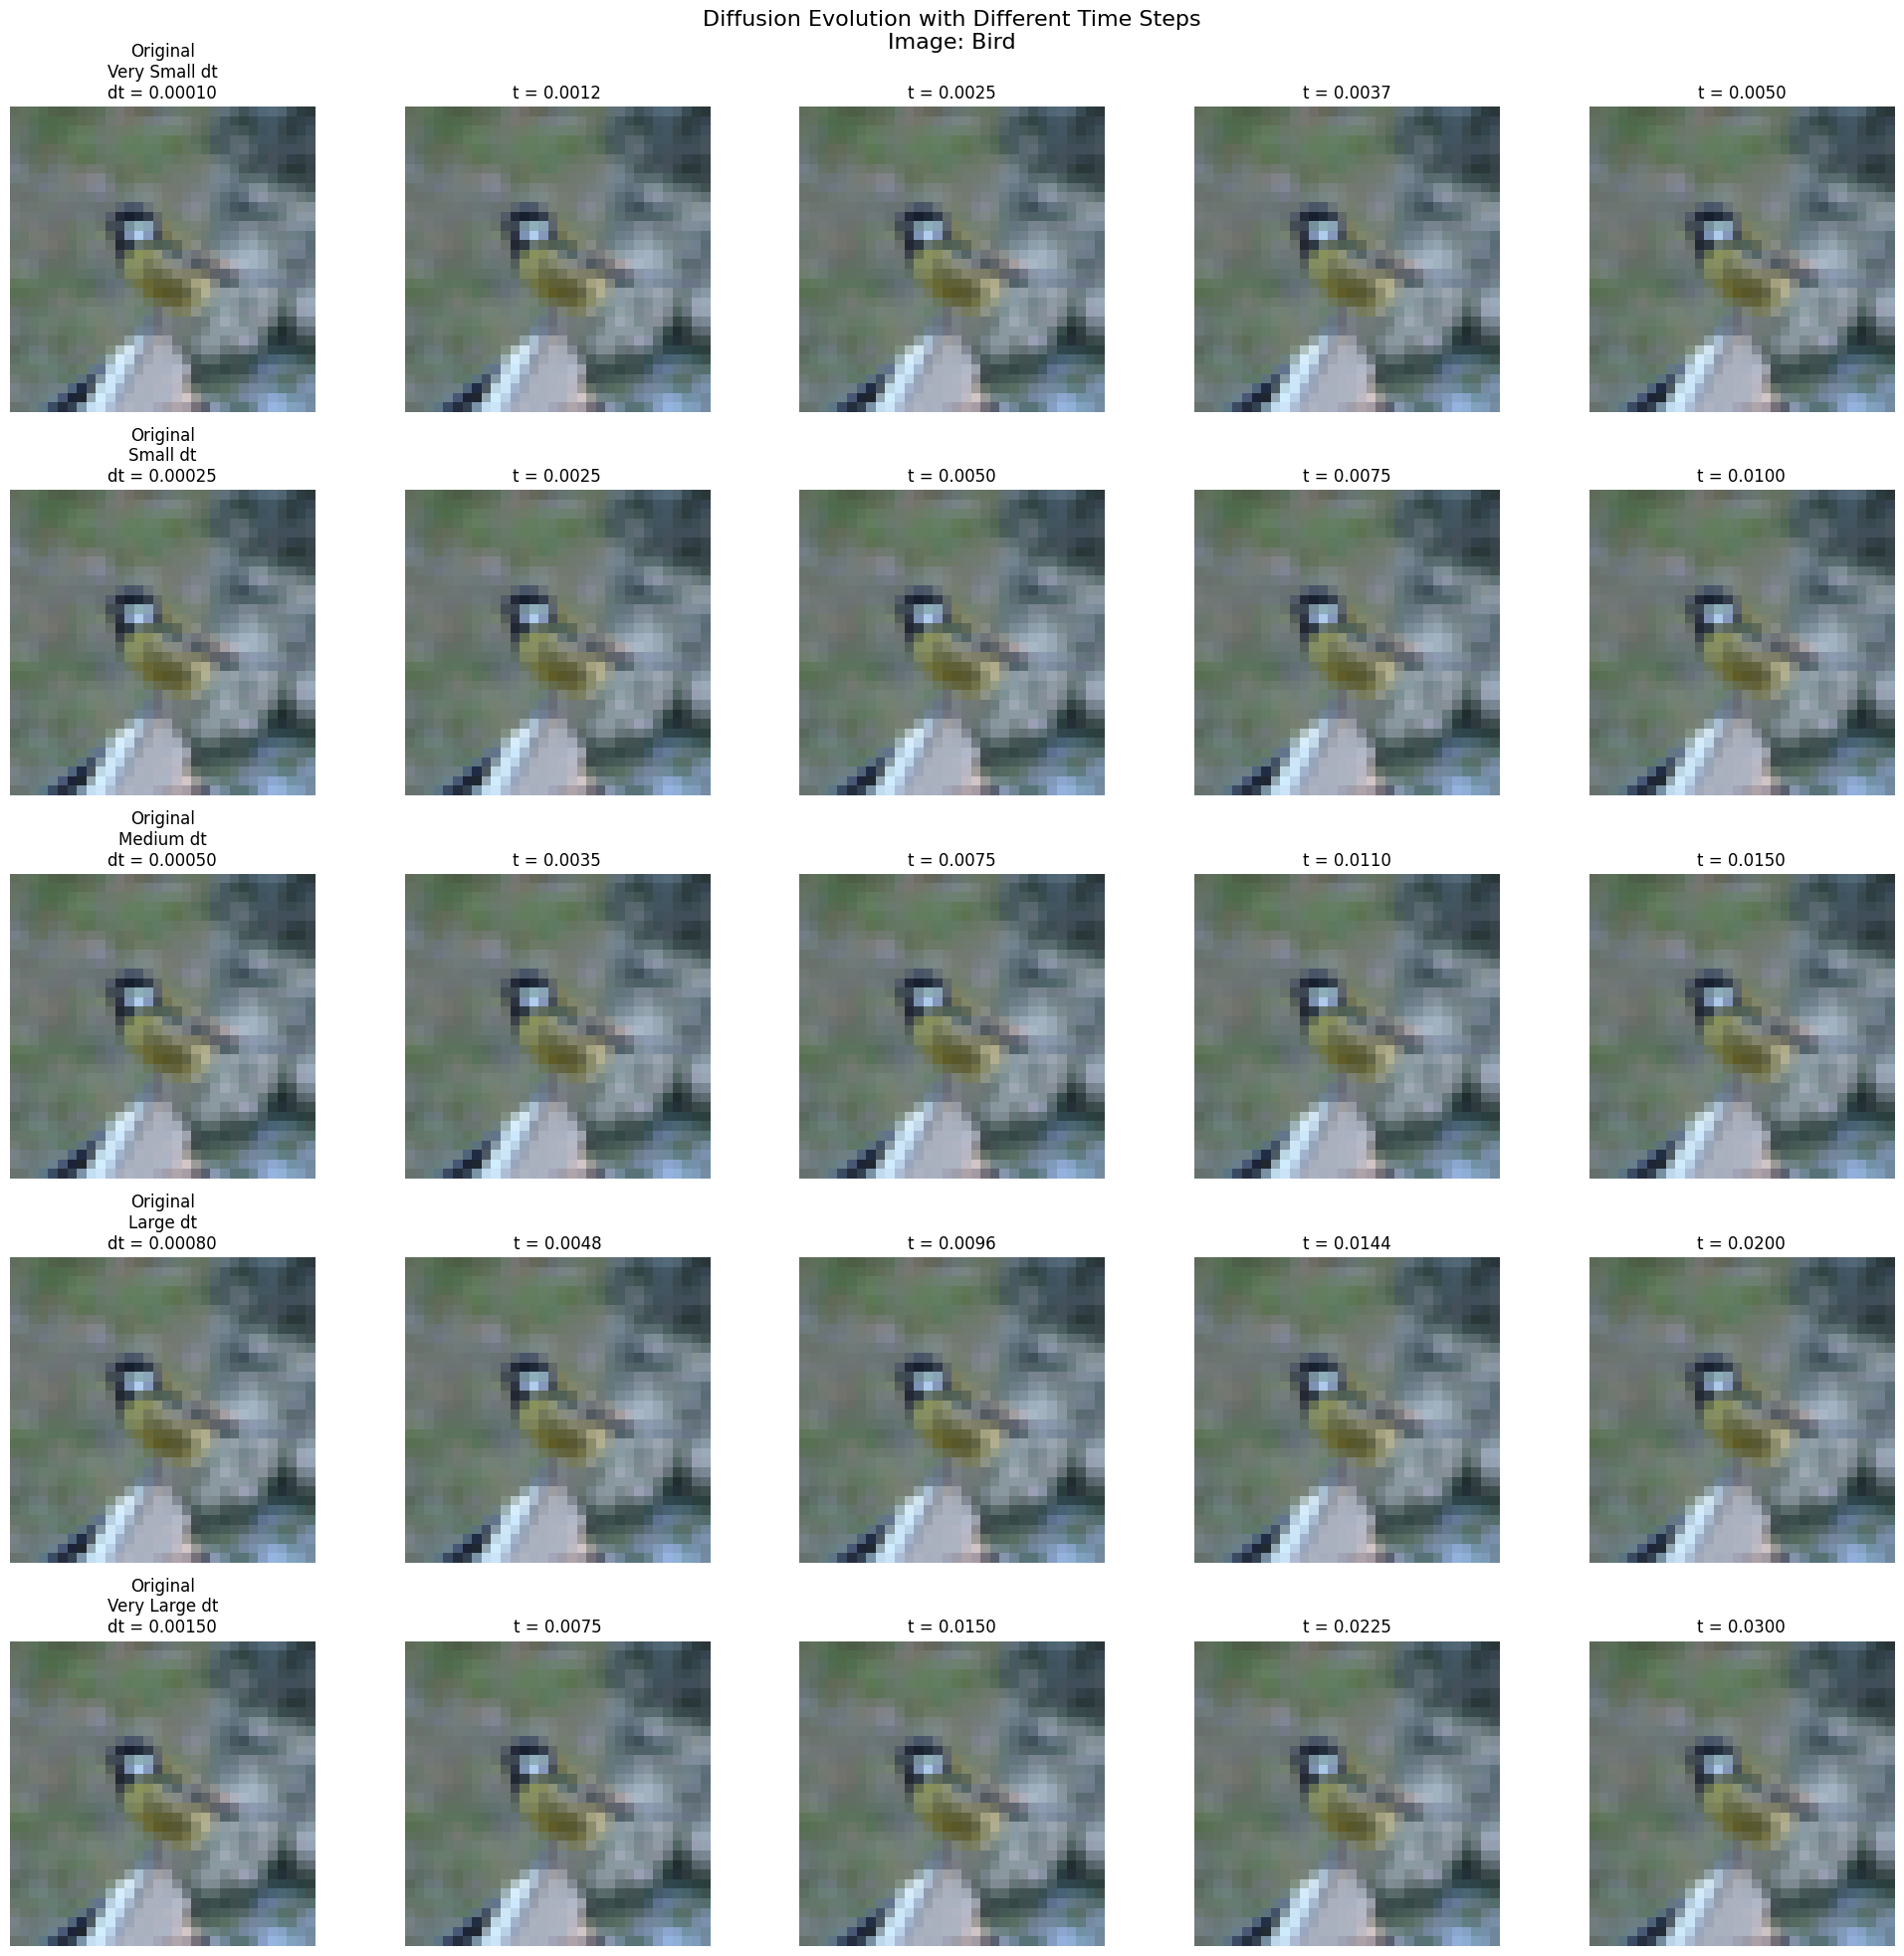

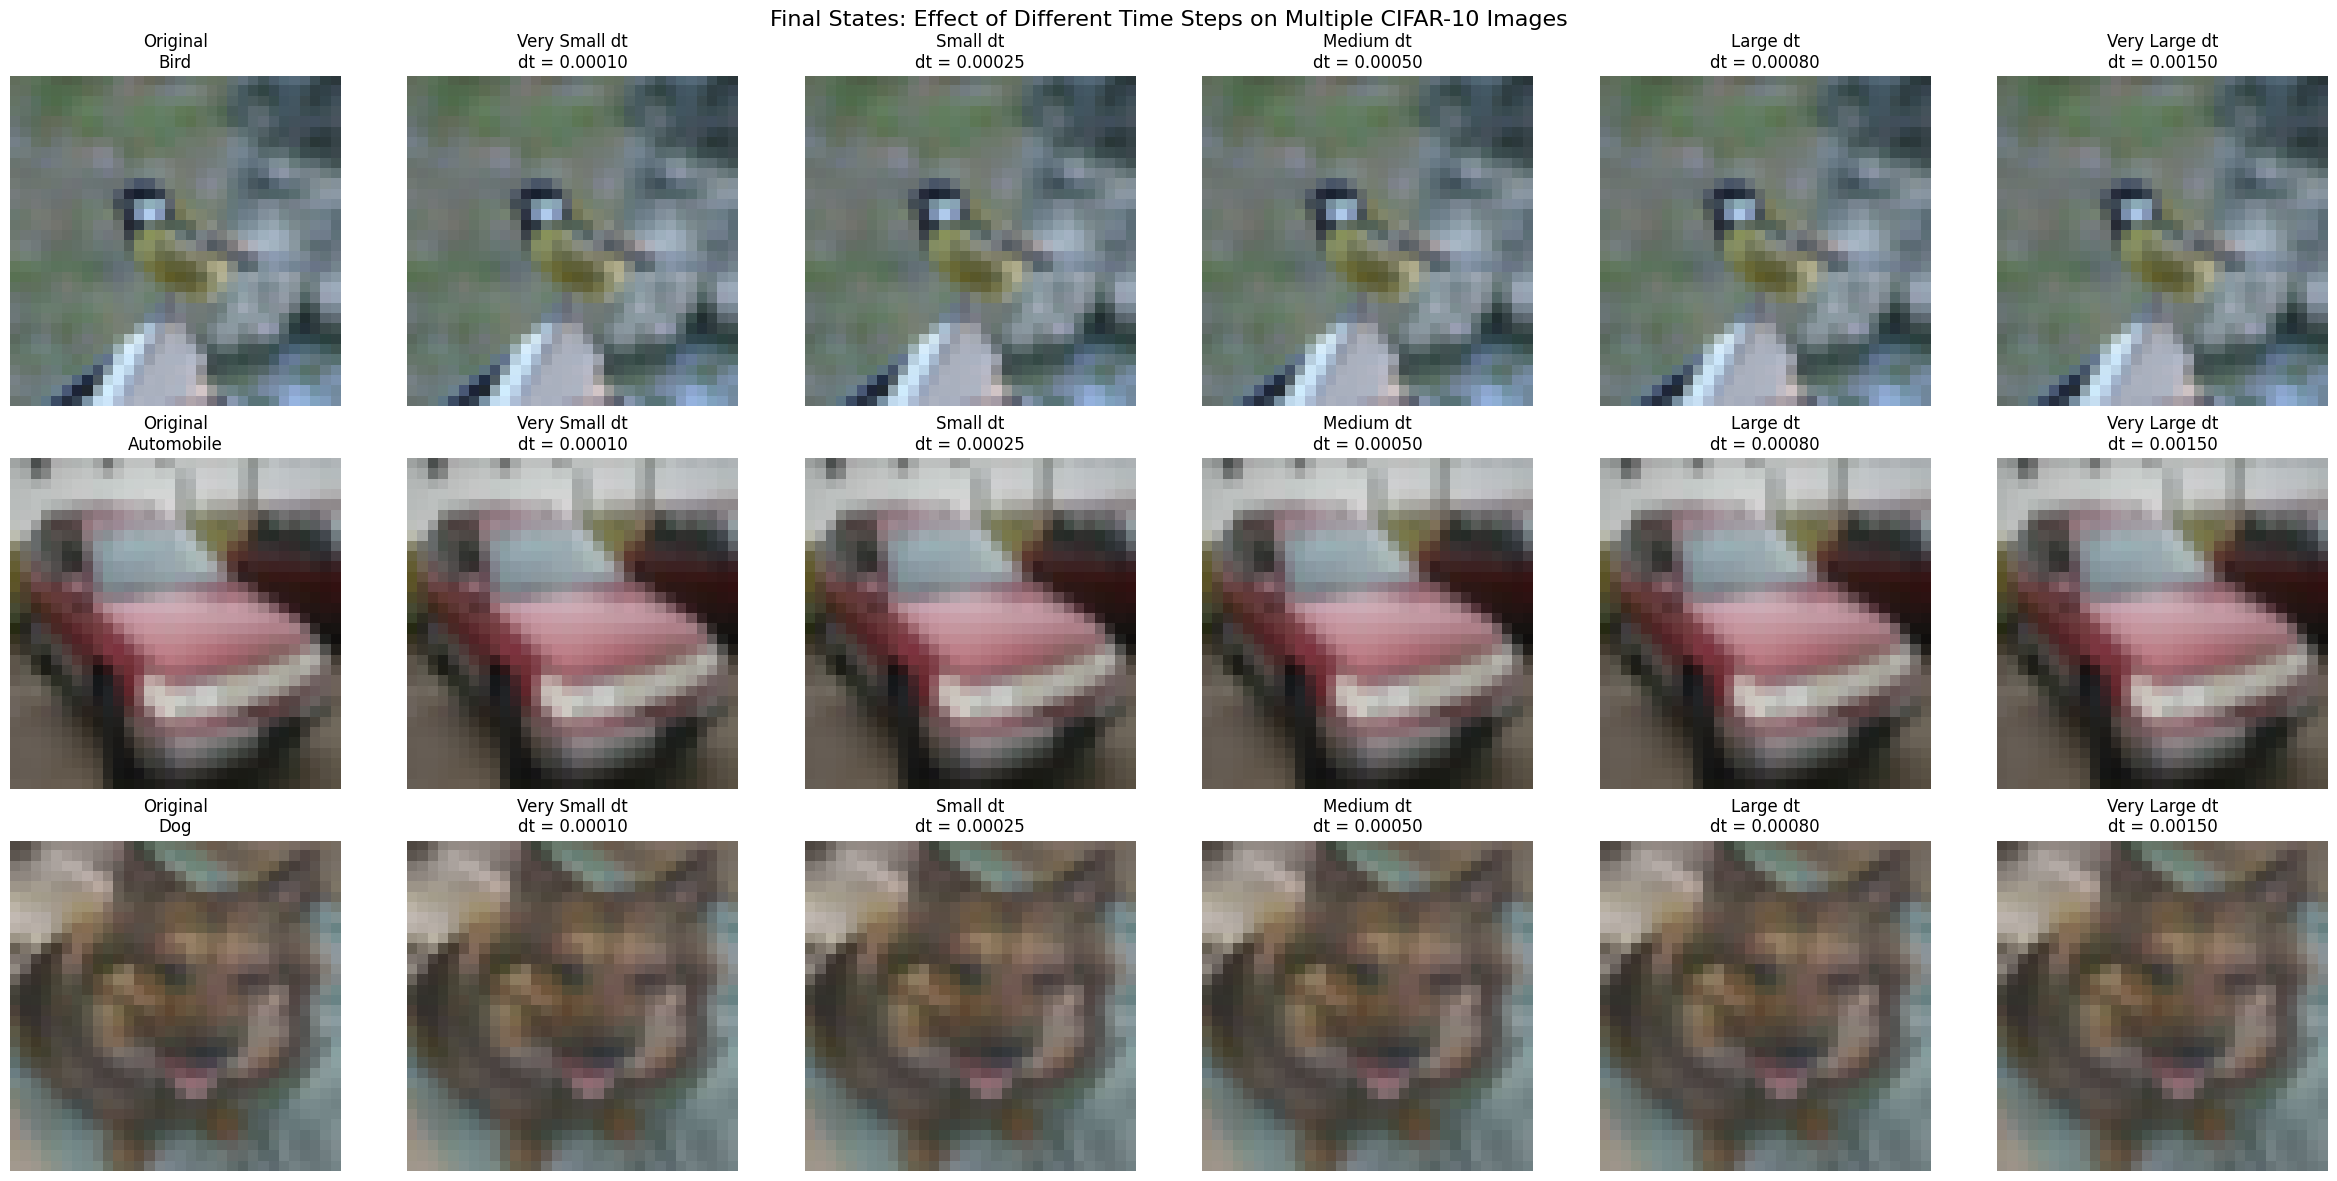


QUANTITATIVE ANALYSIS: Effect of Time Step Size

Image 1: Bird
Original - Energy: 44592350.00, Mean: 116.36, Std: 31.26
------------------------------------------------------------
Scenario        dt       Energy     Energy %   Mean     Std     
------------------------------------------------------------
Very Small dt   0.00010  44150783.0 99.0       115.79   31.06   
Small dt        0.00025  44082027.0 98.9       115.72   30.96   
Medium dt       0.00050  44015463.0 98.7       115.65   30.87   
Large dt        0.00080  43942969.0 98.5       115.58   30.77   
Very Large dt   0.00150  43813184.0 98.3       115.45   30.55   

Image 2: Automobile
Original - Energy: 47253319.00, Mean: 110.71, Std: 55.91
------------------------------------------------------------
Scenario        dt       Energy     Energy %   Mean     Std     
------------------------------------------------------------
Very Small dt   0.00010  46789564.0 99.0       110.11   55.73   
Small dt        0.00025  46733556.0 9

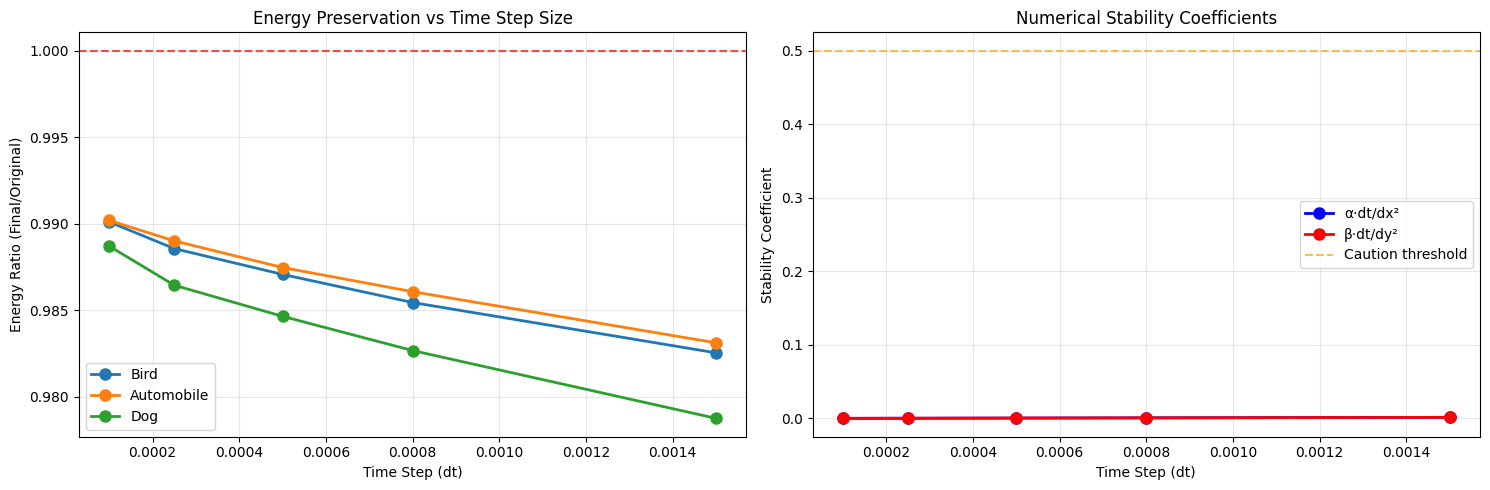


SUMMARY:
- Smaller dt values preserve energy better but require more computation
- Larger dt values cause more diffusion and energy loss
- Stability coefficients > 0.5 may lead to numerical artifacts
- The implicit Strang splitting method remains stable even for aggressive time steps


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Spatial parameters for CIFAR-10 (32x32 images)
Lx, Ly = 1.0, 1.0
Nx, Ny = 32, 32
dx = Lx / (Nx - 1)
dy = Ly / (Ny - 1)

x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)

# Constant diffusion coefficients (scalar case) - INCREASED for visibility
alpha = 0.02   # x-direction diffusion coefficient (20x larger)
beta = 0.02    # y-direction diffusion coefficient (20x larger)

print(f"Diffusion coefficients: α = {alpha}, β = {beta}")
print(f"Spatial resolution: dx = {dx:.4f}, dy = {dy:.4f}")

# Different time step scenarios
dt_scenarios = [
    {"name": "Very Small dt", "T": 0.005, "Nt": 50, "description": "Conservative, high accuracy"},
    {"name": "Small dt", "T": 0.01, "Nt": 40, "description": "Standard stability"},
    {"name": "Medium dt", "T": 0.015, "Nt": 30, "description": "Moderate time step"},
    {"name": "Large dt", "T": 0.02, "Nt": 25, "description": "Aggressive time step"},
    {"name": "Very Large dt", "T": 0.03, "Nt": 20, "description": "Potentially unstable"}
]

# Calculate dt values and stability conditions
print("\nTime Step Analysis:")
print("=" * 80)
print(f"{'Scenario':<15} {'T':<6} {'Nt':<4} {'dt':<8} {'α*dt/dx²':<10} {'β*dt/dy²':<10} {'Status'}")
print("-" * 80)

for scenario in dt_scenarios:
    dt = scenario["T"] / scenario["Nt"]
    scenario["dt"] = dt

    # Stability analysis (for explicit schemes, we need dt < dx²/(2*α) and dt < dy²/(2*β))
    # For implicit schemes, we check the magnitude of the coefficients
    alpha_ratio = alpha * dt / (dx**2)
    beta_ratio = beta * dt / (dy**2)

    # Rule of thumb: for implicit schemes, ratios > 0.5 may cause issues
    status = "Good"
    if alpha_ratio > 0.3 or beta_ratio > 0.3:
        status = "Caution"
    if alpha_ratio > 0.5 or beta_ratio > 0.5:
        status = "Risky"

    print(f"{scenario['name']:<15} {scenario['T']:<6.3f} {scenario['Nt']:<4} {dt:<8.5f} {alpha_ratio:<10.4f} {beta_ratio:<10.4f} {status}")

# Thomas algorithm for tridiagonal system
def thomas(a, b, c, d):
    """Solve tridiagonal system Ax = d using Thomas algorithm"""
    n = len(d)

    if n == 1:
        return d / b

    # Forward elimination
    c_prime = np.zeros(n-1)
    d_prime = np.zeros(n)

    c_prime[0] = c[0] / b[0]
    d_prime[0] = d[0] / b[0]

    for i in range(1, n-1):
        denom = b[i] - a[i-1] * c_prime[i-1]
        c_prime[i] = c[i] / denom
        d_prime[i] = (d[i] - a[i-1] * d_prime[i-1]) / denom

    d_prime[-1] = (d[-1] - a[-2] * d_prime[-2]) / (b[-1] - a[-2] * c_prime[-2])

    # Back substitution
    x = np.zeros(n)
    x[-1] = d_prime[-1]
    for i in reversed(range(n-1)):
        x[i] = d_prime[i] - c_prime[i] * x[i+1]

    return x

def solve_pde_channel(initial_condition, dt, Nt):
    """Solve 2D diffusion equation for a single channel using Strang splitting"""
    # Normalize to [0, 1]
    u = initial_condition.astype(np.float64) / 255.0

    # Store evolution at specific steps
    save_steps = [Nt//4, Nt//2, 3*Nt//4, Nt]
    evolution = [(0.0, u.copy())]

    # Time stepping using Strang splitting
    for n in range(Nt):
        t = n * dt

        # Step 1: half-step in x-direction
        u_half = np.copy(u)
        a_x = -0.5 * dt * alpha / (dx**2)
        b_x = 1 - 2 * a_x

        A_x = np.full(Nx-1, a_x)
        B_x = np.full(Nx, b_x)
        C_x = np.full(Nx-1, a_x)

        for j in range(Ny):
            u_half[:, j] = thomas(A_x, B_x, C_x, u[:, j])

        # Step 2: full-step in y-direction
        u_temp = np.copy(u_half)
        b_y = -dt * beta / (dy**2)
        c_y = 1 - 2 * b_y

        A_y = np.full(Ny-1, b_y)
        B_y = np.full(Ny, c_y)
        C_y = np.full(Ny-1, b_y)

        for i in range(Nx):
            u_temp[i, :] = thomas(A_y, B_y, C_y, u_half[i, :])

        # Step 3: half-step in x-direction
        u_half2 = np.copy(u_temp)
        for j in range(Ny):
            u_half2[:, j] = thomas(A_x, B_x, C_x, u_temp[:, j])

        u = u_half2

        # Store at specific steps
        if (n + 1) in save_steps:
            current_time = (n + 1) * dt
            evolution.append((current_time, u.copy()))

    return u, evolution

def solve_pde_rgb(rgb_image, dt, Nt):
    """Solve PDE for all RGB channels"""
    results = []
    evolutions = []

    for channel in range(3):
        result, evolution = solve_pde_channel(rgb_image[:, :, channel], dt, Nt)
        results.append(result)
        evolutions.append(evolution)

    # Combine channels
    final_rgb = np.stack(results, axis=2)
    final_rgb = np.clip(final_rgb * 255, 0, 255).astype(np.uint8)

    return final_rgb, evolutions

# Select random CIFAR-10 images
np.random.seed(42)
num_test_images = 3
test_indices = np.random.choice(len(x_test), num_test_images, replace=False)

print(f"\nSelected test images:")
for i, idx in enumerate(test_indices):
    label = class_names[y_test[idx][0]]
    print(f"Image {i+1}: {label} (index {idx})")

# Process each image with different dt values
results_all = {}
for img_idx, test_idx in enumerate(test_indices):
    test_image = x_test[test_idx]
    test_label = class_names[y_test[test_idx][0]]

    print(f"\nProcessing {test_label} image...")

    results_all[img_idx] = {
        'image': test_image,
        'label': test_label,
        'results': {}
    }

    for scenario in dt_scenarios:
        print(f"  - {scenario['name']} (dt = {scenario['dt']:.5f})...")

        final_image, evolutions = solve_pde_rgb(
            test_image,
            scenario['dt'],
            scenario['Nt']
        )

        results_all[img_idx]['results'][scenario['name']] = {
            'final': final_image,
            'evolution': evolutions,
            'scenario': scenario
        }

# Visualization 1: Evolution comparison for first image
img_idx = 0
test_image = results_all[img_idx]['image']
test_label = results_all[img_idx]['label']

fig, axes = plt.subplots(len(dt_scenarios), 5, figsize=(20, 4*len(dt_scenarios)))
fig.suptitle(f'Diffusion Evolution with Different Time Steps\nImage: {test_label.title()}', fontsize=16)

for row, scenario in enumerate(dt_scenarios):
    scenario_results = results_all[img_idx]['results'][scenario['name']]
    evolutions = scenario_results['evolution']

    # Original image
    axes[row, 0].imshow(test_image)
    axes[row, 0].set_title(f'Original\n{scenario["name"]}\ndt = {scenario["dt"]:.5f}')
    axes[row, 0].axis('off')

    # Evolution steps
    for step_idx in range(1, 5):
        if step_idx < len(evolutions[0]):
            time_val, _ = evolutions[0][step_idx]

            # Combine RGB channels
            rgb_step = np.zeros((32, 32, 3))
            for c in range(3):
                if step_idx < len(evolutions[c]):
                    _, img_data = evolutions[c][step_idx]
                    rgb_step[:, :, c] = img_data

            rgb_step = np.clip(rgb_step * 255, 0, 255).astype(np.uint8)

            axes[row, step_idx].imshow(rgb_step)
            axes[row, step_idx].set_title(f't = {time_val:.4f}')
            axes[row, step_idx].axis('off')
        else:
            axes[row, step_idx].axis('off')

plt.tight_layout()
plt.show()

# Visualization 2: Final states comparison for all images
fig, axes = plt.subplots(num_test_images, len(dt_scenarios) + 1, figsize=(4*(len(dt_scenarios) + 1), 4*num_test_images))
fig.suptitle('Final States: Effect of Different Time Steps on Multiple CIFAR-10 Images', fontsize=16)

for img_idx in range(num_test_images):
    test_image = results_all[img_idx]['image']
    test_label = results_all[img_idx]['label']

    # Original image
    axes[img_idx, 0].imshow(test_image)
    axes[img_idx, 0].set_title(f'Original\n{test_label.title()}')
    axes[img_idx, 0].axis('off')

    # Results for different dt values
    for col, scenario in enumerate(dt_scenarios):
        final_image = results_all[img_idx]['results'][scenario['name']]['final']

        axes[img_idx, col + 1].imshow(final_image)
        axes[img_idx, col + 1].set_title(f'{scenario["name"]}\ndt = {scenario["dt"]:.5f}')
        axes[img_idx, col + 1].axis('off')

plt.tight_layout()
plt.show()

# Quantitative analysis
print("\n" + "="*80)
print("QUANTITATIVE ANALYSIS: Effect of Time Step Size")
print("="*80)

for img_idx in range(num_test_images):
    test_image = results_all[img_idx]['image']
    test_label = results_all[img_idx]['label']
    original_energy = np.sum(test_image.astype(np.float64)**2)
    original_mean = np.mean(test_image)
    original_std = np.std(test_image)

    print(f"\nImage {img_idx + 1}: {test_label.title()}")
    print(f"Original - Energy: {original_energy:.2f}, Mean: {original_mean:.2f}, Std: {original_std:.2f}")
    print("-" * 60)
    print(f"{'Scenario':<15} {'dt':<8} {'Energy':<10} {'Energy %':<10} {'Mean':<8} {'Std':<8}")
    print("-" * 60)

    for scenario in dt_scenarios:
        final_image = results_all[img_idx]['results'][scenario['name']]['final']
        final_energy = np.sum(final_image.astype(np.float64)**2)
        energy_ratio = (final_energy / original_energy) * 100
        final_mean = np.mean(final_image)
        final_std = np.std(final_image)

        print(f"{scenario['name']:<15} {scenario['dt']:<8.5f} {final_energy:<10.1f} {energy_ratio:<10.1f} {final_mean:<8.2f} {final_std:<8.2f}")

# Energy preservation analysis
print(f"\n" + "="*80)
print("ENERGY PRESERVATION ANALYSIS")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Energy preservation vs dt
dt_values = [scenario['dt'] for scenario in dt_scenarios]
scenario_names = [scenario['name'] for scenario in dt_scenarios]

for img_idx in range(num_test_images):
    test_image = results_all[img_idx]['image']
    test_label = results_all[img_idx]['label']
    original_energy = np.sum(test_image.astype(np.float64)**2)

    energy_ratios = []
    for scenario in dt_scenarios:
        final_image = results_all[img_idx]['results'][scenario['name']]['final']
        final_energy = np.sum(final_image.astype(np.float64)**2)
        energy_ratios.append(final_energy / original_energy)

    axes[0].plot(dt_values, energy_ratios, 'o-', label=f'{test_label.title()}', linewidth=2, markersize=8)

axes[0].set_xlabel('Time Step (dt)')
axes[0].set_ylabel('Energy Ratio (Final/Original)')
axes[0].set_title('Energy Preservation vs Time Step Size')
axes[0].grid(True, alpha=0.3)
axes[0].legend()
axes[0].axhline(y=1.0, color='r', linestyle='--', alpha=0.7, label='Perfect preservation')

# Stability coefficient analysis
alpha_ratios = [alpha * scenario['dt'] / (dx**2) for scenario in dt_scenarios]
beta_ratios = [beta * scenario['dt'] / (dy**2) for scenario in dt_scenarios]

axes[1].plot(dt_values, alpha_ratios, 'bo-', label='α·dt/dx²', linewidth=2, markersize=8)
axes[1].plot(dt_values, beta_ratios, 'ro-', label='β·dt/dy²', linewidth=2, markersize=8)
axes[1].axhline(y=0.5, color='orange', linestyle='--', alpha=0.7, label='Caution threshold')
axes[1].set_xlabel('Time Step (dt)')
axes[1].set_ylabel('Stability Coefficient')
axes[1].set_title('Numerical Stability Coefficients')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\nSUMMARY:")
print("- Smaller dt values preserve energy better but require more computation")
print("- Larger dt values cause more diffusion and energy loss")
print("- Stability coefficients > 0.5 may lead to numerical artifacts")
print("- The implicit Strang splitting method remains stable even for aggressive time steps")

Starting PDE diffusion training on SVHN dataset...
Using device: cuda
Model parameters: 9,070,356
Starting heavily optimized SVHN PDE training...
Epoch 1, Batch 0, Loss: 2.4302, Acc: 10.94%, LR: 0.000400
Epoch 1, Batch 50, Loss: 2.2811, Acc: 15.69%, LR: 0.000437
Epoch 1, Batch 100, Loss: 2.2332, Acc: 16.60%, LR: 0.000544
Epoch 1, Batch 150, Loss: 2.0789, Acc: 19.17%, LR: 0.000721
Epoch 1, Batch 200, Loss: 1.6776, Acc: 23.09%, LR: 0.000963
Epoch 1, Batch 250, Loss: 1.5880, Acc: 26.73%, LR: 0.001269
✓ New best validation accuracy: 51.26%
Epoch 1 - Loss: 1.9817, Train Acc: 29.12%, Val Acc: 51.26%, Time: 1426.21s
Alpha - Base: μ=0.100, σ=0.000 | Time: μ=-0.000, σ=0.001
Beta - Base: μ=0.100, σ=0.000 | Time: μ=0.000, σ=0.001
Channel coupling strength: 0.0173
--------------------------------------------------------------------------------
Epoch 2, Batch 0, Loss: 1.4019, Acc: 51.95%, LR: 0.001532
Epoch 2, Batch 50, Loss: 1.5107, Acc: 50.41%, LR: 0.001935
Epoch 2, Batch 100, Loss: 1.4616, Acc: 

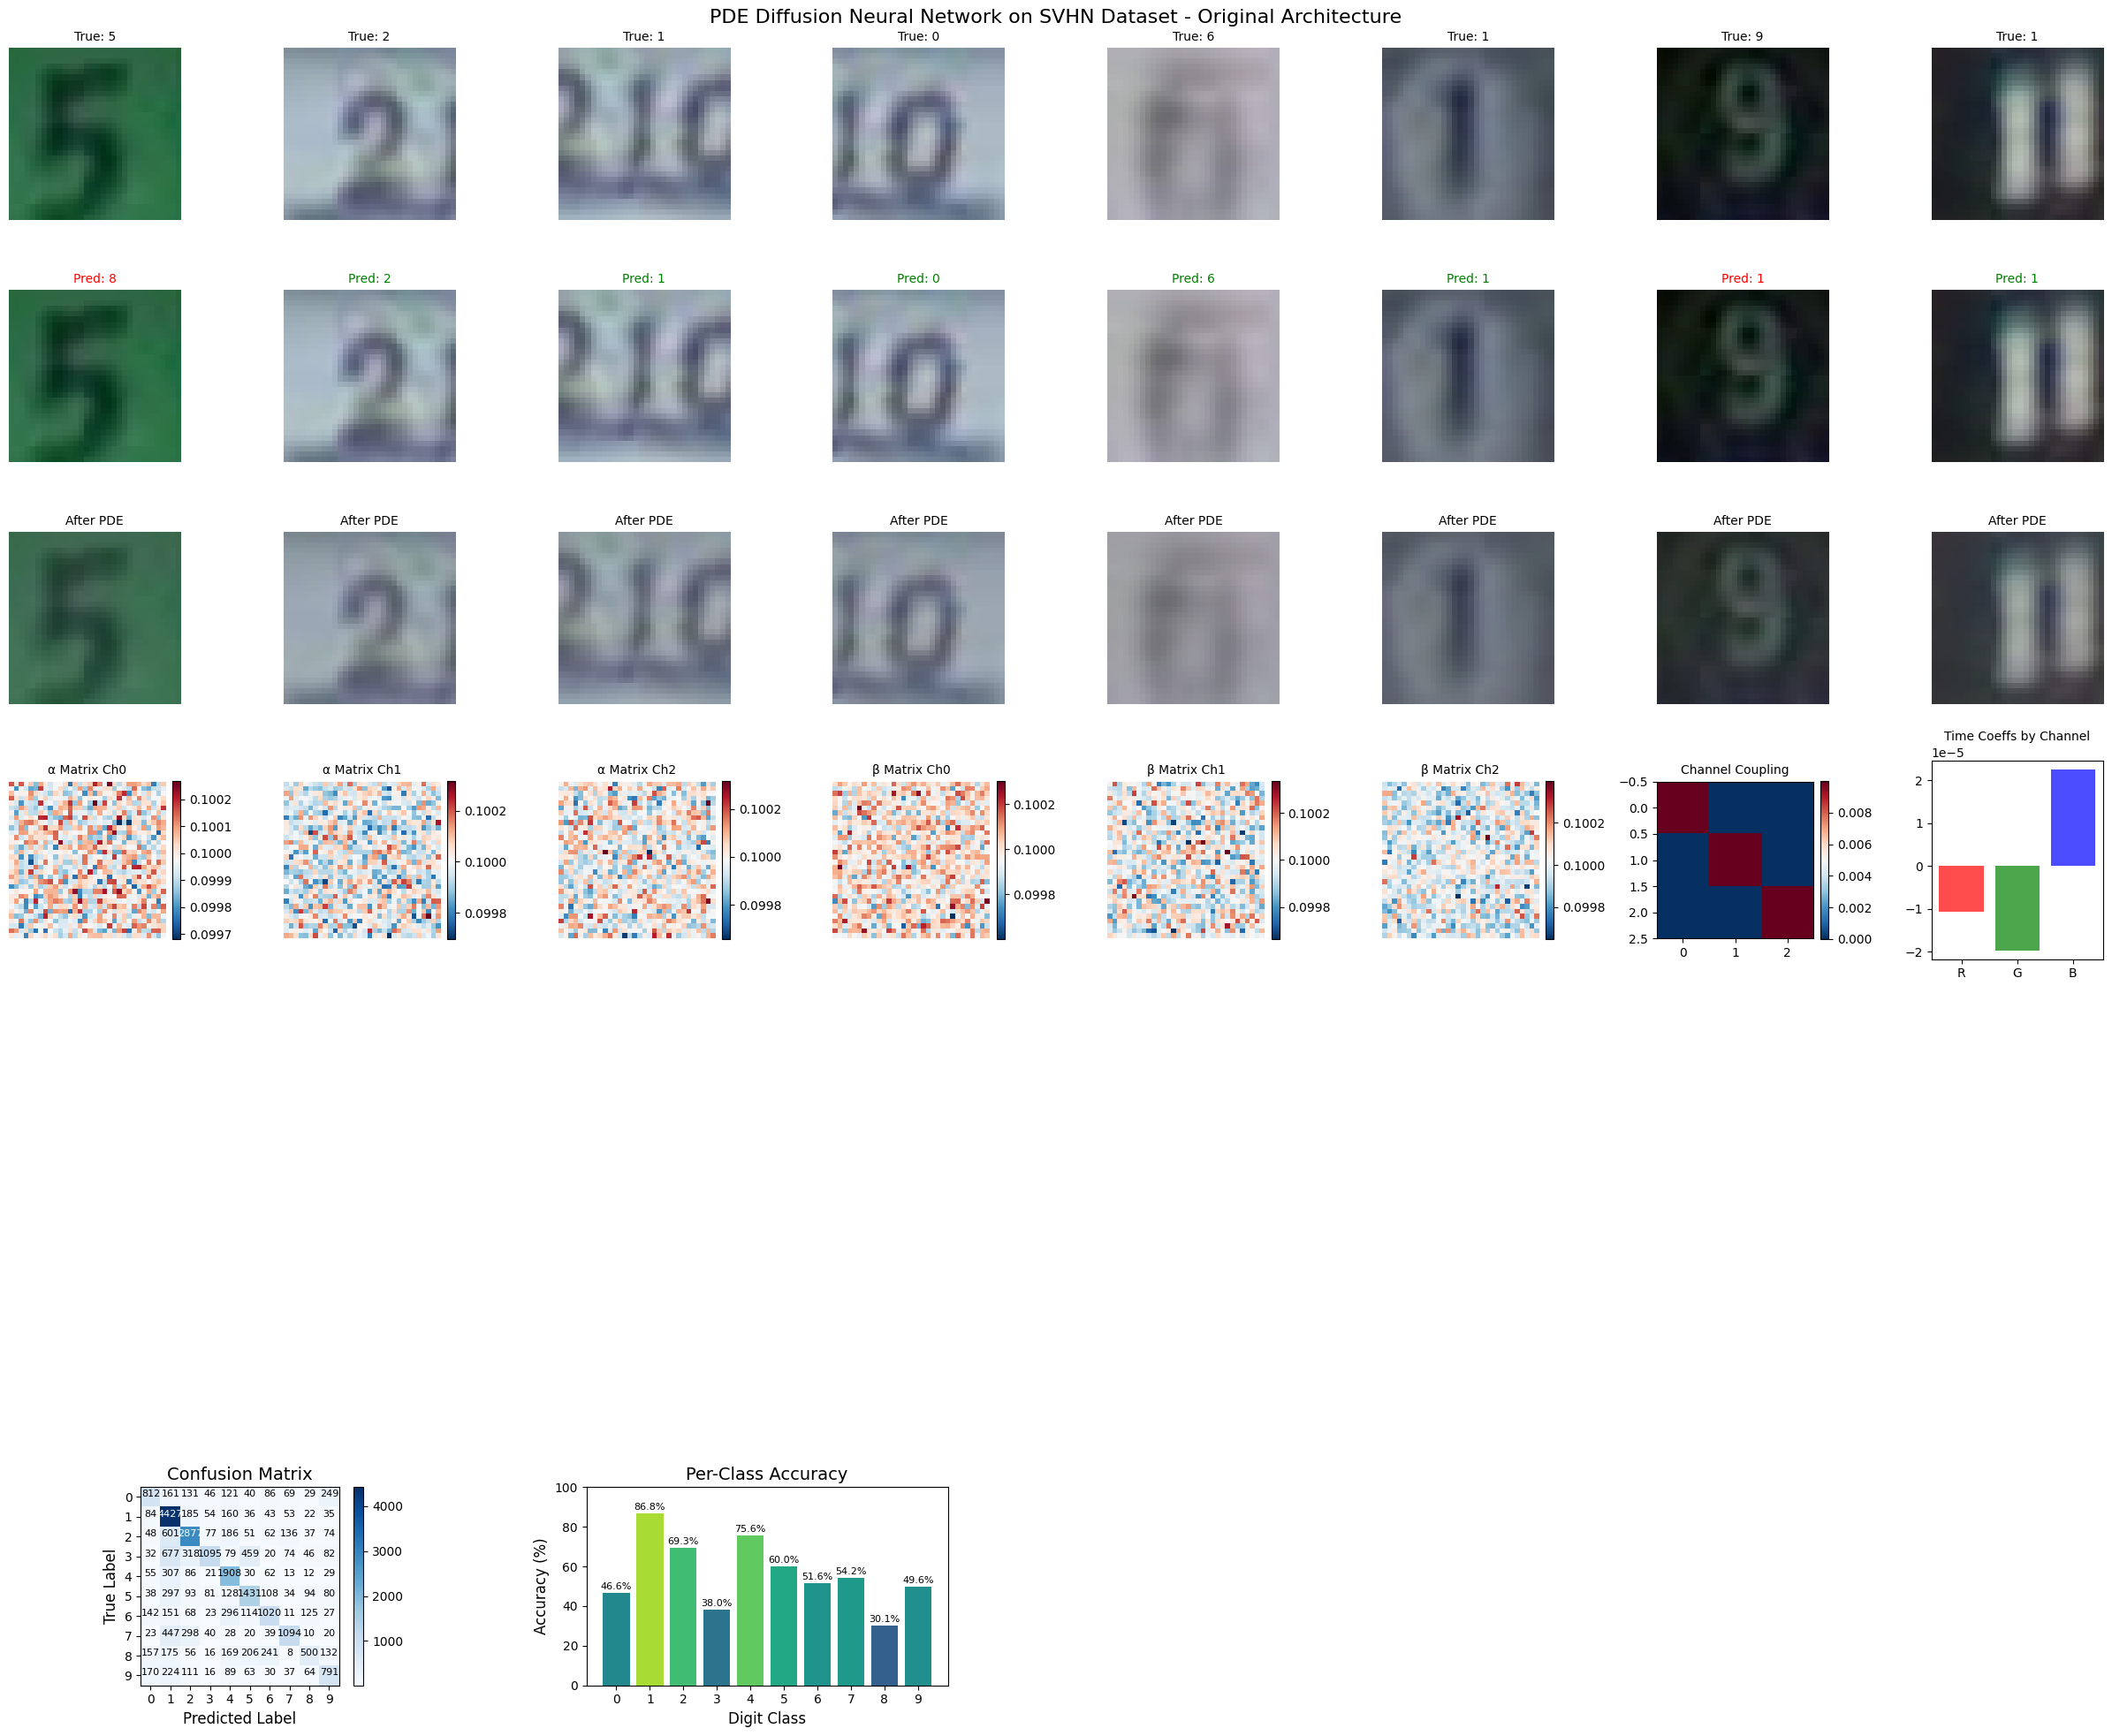


Detailed Metrics:
Overall Accuracy: 61.29%
Best performing class: 1 (86.82%)
Worst performing class: 8 (30.12%)
Standard deviation of class accuracies: 16.36%


In [ ]:
# PDE Diffusion Neural Network adapted for SVHN Dataset
# SVHN: 32x32 RGB images, 10 digit classes
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# --- Enhanced PDE Diffusion Layer for RGB Images ---
class DiffusionLayer(nn.Module):
    def __init__(self, size=32, channels=3, dt=0.01, dx=1.0, num_steps=10):
        super().__init__()
        self.size = size
        self.channels = channels
        self.dt = dt
        self.dx = dx
        self.num_steps = num_steps

        # Very small diffusion coefficients to preserve image details
        self.alpha_base = nn.Parameter(torch.ones(channels, size, size) * 0.1)
        self.beta_base = nn.Parameter(torch.ones(channels, size, size) * 0.1)

        # Very small time-dependent modulation
        self.alpha_time_coeff = nn.Parameter(torch.randn(channels, size, size) * 0.001)
        self.beta_time_coeff = nn.Parameter(torch.randn(channels, size, size) * 0.001)

        # Minimal channel coupling
        self.channel_coupling = nn.Parameter(torch.eye(channels) * 0.01)

        # Stability parameters
        self.stability_eps = 1e-6

        # Add learnable skip connection weight
        self.skip_weight = nn.Parameter(torch.tensor(0.9))  # Start with mostly original image

    def get_alpha_beta_at_time(self, t):
        """Get alpha and beta coefficient matrices at time t for all channels"""
        alpha_t = self.alpha_base + self.alpha_time_coeff * t
        beta_t = self.beta_base + self.beta_time_coeff * t

        # Ensure positive coefficients for stability
        alpha_t = torch.clamp(alpha_t, min=self.stability_eps)
        beta_t = torch.clamp(beta_t, min=self.stability_eps)

        return alpha_t, beta_t

    def forward(self, u):
        B, C, H, W = u.shape
        original_u = u.clone()  # Keep original for skip connection

        # Apply very minimal diffusion steps
        current_time = 0.0
        for step in range(self.num_steps):
            # Get alpha and beta matrices at current time
            alpha_t, beta_t = self.get_alpha_beta_at_time(current_time)

            # Very light diffusion - mostly preserve original
            u = self.diffuse_x_vectorized(u, alpha_t, self.dt / 2, self.dx)
            current_time += self.dt / 2

            alpha_t, beta_t = self.get_alpha_beta_at_time(current_time)
            u = self.diffuse_y_vectorized(u, beta_t, self.dt, self.dx)
            current_time += self.dt / 2

            alpha_t, beta_t = self.get_alpha_beta_at_time(current_time)
            u = self.diffuse_x_vectorized(u, alpha_t, self.dt / 2, self.dx)

            # Very minimal channel coupling
            u = self.apply_channel_coupling(u)

        # Learnable skip connection - mostly keep original image
        u = torch.sigmoid(self.skip_weight) * original_u + (1 - torch.sigmoid(self.skip_weight)) * u

        return u

    def apply_channel_coupling(self, u):
        """Apply cross-channel diffusion coupling"""
        B, C, H, W = u.shape
        # Reshape to (B, H*W, C) for matrix multiplication
        u_reshaped = u.permute(0, 2, 3, 1).contiguous().view(B * H * W, C)
        # Apply channel coupling matrix
        u_coupled = torch.matmul(u_reshaped, self.channel_coupling.t())
        # Reshape back to (B, C, H, W)
        return u_coupled.view(B, H, W, C).permute(0, 3, 1, 2).contiguous()

    def diffuse_x_vectorized(self, u, alpha_matrix, dt, dx):
        """Vectorized diffusion in x-direction for multi-channel data"""
        B, C, H, W = u.shape
        device = u.device

        # Process each channel separately
        results = []
        for c in range(C):
            # Extract channel data: (B, H, W)
            u_channel = u[:, c, :, :]
            alpha_channel = alpha_matrix[c]  # (H, W)

            # Reshape for batch processing: (B, H, W) -> (B*H, W)
            u_flat = u_channel.contiguous().view(B * H, W)

            # Expand alpha_matrix for all batches: (H, W) -> (B*H, W)
            alpha_expanded = alpha_channel.unsqueeze(0).expand(B, -1, -1).contiguous().view(B * H, W)

            # Apply smoothing to coefficients for stability
            alpha_smooth = self.smooth_coefficients(alpha_expanded, dim=1)
            coeff = alpha_smooth * dt / (dx ** 2)

            # Build tridiagonal system coefficients
            a = -coeff  # sub-diagonal
            c_coeff = -coeff  # super-diagonal
            b = 1 + 2 * coeff  # main diagonal

            # Apply boundary conditions (Neumann - no flux at boundaries)
            b_modified = b.clone()
            b_modified[:, 0] = 1 + coeff[:, 0]
            b_modified[:, -1] = 1 + coeff[:, -1]

            # Solve all tridiagonal systems in parallel
            result = self.thomas_solver_batch(a, b_modified, c_coeff, u_flat)
            results.append(result.view(B, H, W))

        return torch.stack(results, dim=1)  # Stack channels back: (B, C, H, W)

    def diffuse_y_vectorized(self, u, beta_matrix, dt, dx):
        """Vectorized diffusion in y-direction for multi-channel data"""
        B, C, H, W = u.shape
        device = u.device

        # Process each channel separately
        results = []
        for c in range(C):
            # Extract channel data: (B, H, W)
            u_channel = u[:, c, :, :]
            beta_channel = beta_matrix[c]  # (H, W)

            # Transpose to work on columns: (B, H, W) -> (B, W, H)
            u_t = u_channel.transpose(1, 2).contiguous()
            u_flat = u_t.view(B * W, H)

            # Expand beta_matrix for all batches: (H, W) -> (B*W, H)
            beta_expanded = beta_channel.t().unsqueeze(0).expand(B, -1, -1).contiguous().view(B * W, H)

            # Apply smoothing to coefficients for stability
            beta_smooth = self.smooth_coefficients(beta_expanded, dim=1)
            coeff = beta_smooth * dt / (dx ** 2)

            # Build tridiagonal system coefficients
            a = -coeff  # sub-diagonal
            c_coeff = -coeff  # super-diagonal
            b = 1 + 2 * coeff  # main diagonal

            # Apply boundary conditions (Neumann - no flux at boundaries)
            b_modified = b.clone()
            b_modified[:, 0] = 1 + coeff[:, 0]
            b_modified[:, -1] = 1 + coeff[:, -1]

            # Solve all tridiagonal systems in parallel
            result = self.thomas_solver_batch(a, b_modified, c_coeff, u_flat)

            # Transpose back: (B*W, H) -> (B, W, H) -> (B, H, W)
            results.append(result.view(B, W, H).transpose(1, 2).contiguous())

        return torch.stack(results, dim=1)  # Stack channels back: (B, C, H, W)

    def smooth_coefficients(self, coeffs, dim=1, kernel_size=3):
        """Apply smoothing to coefficients for numerical stability"""
        if kernel_size == 1:
            return coeffs

        # Simple moving average smoothing using conv1d
        padding = kernel_size // 2
        if dim == 1:
            coeffs_padded = F.pad(coeffs, (padding, padding), mode='replicate')
            kernel = torch.ones(1, 1, kernel_size, device=coeffs.device) / kernel_size
            smoothed = F.conv1d(coeffs_padded.unsqueeze(1), kernel, padding=0).squeeze(1)
        else:
            raise NotImplementedError("Only dim=1 smoothing implemented")

        return smoothed

    def thomas_solver_batch(self, a, b, c, d):
        """
        Batch Thomas algorithm - no in-place operations
        All inputs have shape (batch_size, N)
        """
        batch_size, N = d.shape
        device = d.device
        eps = self.stability_eps

        # Initialize working arrays
        c_star = torch.zeros_like(d)
        d_star = torch.zeros_like(d)

        # Forward elimination with numerical stability
        c_star = c_star.clone()
        d_star = d_star.clone()

        # First step
        denom_0 = b[:, 0] + eps
        c_star = c_star.scatter(1, torch.zeros(batch_size, 1, dtype=torch.long, device=device),
                               (c[:, 0] / denom_0).unsqueeze(1))
        d_star = d_star.scatter(1, torch.zeros(batch_size, 1, dtype=torch.long, device=device),
                               (d[:, 0] / denom_0).unsqueeze(1))

        # Forward sweep
        for i in range(1, N):
            denom = b[:, i] - a[:, i] * c_star[:, i-1] + eps

            if i < N-1:
                c_star = c_star.scatter(1, torch.full((batch_size, 1), i, dtype=torch.long, device=device),
                                       (c[:, i] / denom).unsqueeze(1))

            d_val = (d[:, i] - a[:, i] * d_star[:, i-1]) / denom
            d_star = d_star.scatter(1, torch.full((batch_size, 1), i, dtype=torch.long, device=device),
                                   d_val.unsqueeze(1))

        # Back substitution
        x = torch.zeros_like(d)
        x = x.scatter(1, torch.full((batch_size, 1), N-1, dtype=torch.long, device=device),
                     d_star[:, -1].unsqueeze(1))

        # Backward sweep
        for i in range(N-2, -1, -1):
            x_val = d_star[:, i] - c_star[:, i] * x[:, i+1]
            x = x.scatter(1, torch.full((batch_size, 1), i, dtype=torch.long, device=device),
                         x_val.unsqueeze(1))

        return x


# --- Much Improved PDE Neural Network for SVHN ---
class PDEClassifier(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super().__init__()
        # Very conservative PDE Diffusion layer
        self.diff = DiffusionLayer(size=32, channels=3)

        # Much larger network to compensate for limited feature extraction
        self.dropout = nn.Dropout(dropout_rate)

        # Bigger first layer to capture more features
        self.fc1 = nn.Linear(32 * 32 * 3, 2048)  # Much larger
        self.bn1 = nn.BatchNorm1d(2048)

        self.fc2 = nn.Linear(2048, 1024)
        self.bn2 = nn.BatchNorm1d(1024)

        self.fc3 = nn.Linear(1024, 512)
        self.bn3 = nn.BatchNorm1d(512)

        self.fc4 = nn.Linear(512, 256)
        self.bn4 = nn.BatchNorm1d(256)

        self.fc5 = nn.Linear(256, 10)  # Output layer

    def forward(self, x):
        # Apply very light PDE diffusion (mostly skip connection)
        x = self.diff(x)

        # Flatten and classify with batch norm and deeper network
        x = x.reshape(x.size(0), -1)

        x = self.dropout(F.relu(self.bn1(self.fc1(x))))
        x = self.dropout(F.relu(self.bn2(self.fc2(x))))
        x = self.dropout(F.relu(self.bn3(self.fc3(x))))
        x = self.dropout(F.relu(self.bn4(self.fc4(x))))

        return self.fc5(x)


# --- Training Setup for SVHN ---
def create_svhn_data_loaders(batch_size=256):
    """Create SVHN data loaders with minimal preprocessing"""
    # Very simple transforms - let the network learn from raw data
    transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4377, 0.4438, 0.4728), (0.1980, 0.2010, 0.1970))  # Just normalization
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4377, 0.4438, 0.4728), (0.1980, 0.2010, 0.1970))
    ])

    # SVHN dataset
    train_loader = DataLoader(
        datasets.SVHN('./data', split='train', download=True, transform=transform_train),
        batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True
    )
    test_loader = DataLoader(
        datasets.SVHN('./data', split='test', download=True, transform=transform_test),
        batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True
    )

    return train_loader, test_loader


def train_model():
    """Training function adapted for SVHN"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Create data loaders
    train_loader, test_loader = create_svhn_data_loaders(batch_size=256)

    # Initialize model
    model = PDEClassifier().to(device)
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    # More aggressive training settings
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-4)  # Much higher LR
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, epochs=15, steps_per_epoch=len(train_loader))
    criterion = nn.CrossEntropyLoss()

    # Training loop
    print("Starting heavily optimized SVHN PDE training...")
    import time

    best_acc = 0

    for epoch in range(2):  # More epochs
        start_time = time.time()
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for batch_idx, (imgs, labels) in enumerate(train_loader):
            imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            optimizer.zero_grad()
            output = model(imgs)
            loss = criterion(output, labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()  # Step every batch for OneCycleLR

            total_loss += loss.item()
            pred = output.argmax(dim=1)
            correct += pred.eq(labels).sum().item()
            total += labels.size(0)

            if batch_idx % 50 == 0:  # More frequent logging
                current_lr = scheduler.get_last_lr()[0]
                print(f'Epoch {epoch+1}, Batch {batch_idx}, Loss: {loss.item():.4f}, Acc: {100.*correct/total:.2f}%, LR: {current_lr:.6f}')

        epoch_time = time.time() - start_time
        avg_loss = total_loss / len(train_loader)
        train_acc = 100. * correct / total

        # Quick validation check every few epochs
        if epoch % 2 == 0:
            model.eval()
            val_correct = 0
            val_total = 0
            with torch.no_grad():
                for imgs, labels in test_loader:
                    imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                    output = model(imgs)
                    pred = output.argmax(dim=1)
                    val_correct += pred.eq(labels).sum().item()
                    val_total += labels.size(0)

            val_acc = 100. * val_correct / val_total

            if val_acc > best_acc:
                best_acc = val_acc
                print(f"✓ New best validation accuracy: {best_acc:.2f}%")

            print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, Time: {epoch_time:.2f}s")
        else:
            print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f}, Train Acc: {train_acc:.2f}%, Time: {epoch_time:.2f}s")

        # Monitor PDE parameters
        with torch.no_grad():
            # Alpha statistics across all channels
            alpha_stats = {
                'base_mean': model.diff.alpha_base.mean().item(),
                'base_std': model.diff.alpha_base.std().item(),
                'time_mean': model.diff.alpha_time_coeff.mean().item(),
                'time_std': model.diff.alpha_time_coeff.std().item()
            }
            # Beta statistics across all channels
            beta_stats = {
                'base_mean': model.diff.beta_base.mean().item(),
                'base_std': model.diff.beta_base.std().item(),
                'time_mean': model.diff.beta_time_coeff.mean().item(),
                'time_std': model.diff.beta_time_coeff.std().item()
            }

            print(f"Alpha - Base: μ={alpha_stats['base_mean']:.3f}, σ={alpha_stats['base_std']:.3f} | "
                  f"Time: μ={alpha_stats['time_mean']:.3f}, σ={alpha_stats['time_std']:.3f}")
            print(f"Beta - Base: μ={beta_stats['base_mean']:.3f}, σ={beta_stats['base_std']:.3f} | "
                  f"Time: μ={beta_stats['time_mean']:.3f}, σ={beta_stats['time_std']:.3f}")

            # Channel coupling analysis
            coupling_norm = torch.norm(model.diff.channel_coupling).item()
            print(f"Channel coupling strength: {coupling_norm:.4f}")

        print("-" * 80)

    return model, test_loader


def evaluate_and_visualize(model, test_loader):
    """Evaluation and visualization for SVHN with confusion matrix"""
    device = next(model.parameters()).device
    model.eval()
    test_correct = 0
    test_total = 0

    # For confusion matrix
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            output = model(imgs)
            pred = output.argmax(dim=1)
            test_correct += pred.eq(labels).sum().item()
            test_total += labels.size(0)

            # Collect for confusion matrix
            all_predictions.extend(pred.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_acc = 100. * test_correct / test_total
    print(f"SVHN Test Accuracy: {test_acc:.2f}%")

    # Convert to numpy arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)

    # Calculate confusion matrix
    from sklearn.metrics import confusion_matrix, classification_report
    cm = confusion_matrix(all_labels, all_predictions)

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_predictions, target_names=[str(i) for i in range(10)]))

    # Visualization
    with torch.no_grad():
        images, labels = next(iter(test_loader))
        images = images.to(device)
        outputs = model(images)
        predicted = outputs.argmax(dim=1)

        # Denormalize images for visualization
        mean = torch.tensor([0.4377, 0.4438, 0.4728]).view(1, 3, 1, 1).to(device)
        std = torch.tensor([0.1980, 0.2010, 0.1970]).view(1, 3, 1, 1).to(device)
        images_denorm = images * std + mean
        images_denorm = torch.clamp(images_denorm, 0, 1)

        # Apply PDE diffusion for visualization
        diffused = model.diff(images)
        diffused_denorm = diffused * std + mean
        diffused_denorm = torch.clamp(diffused_denorm, 0, 1)

        # Parameter analysis
        print(f"\nSVHN PDE Parameter Analysis:")
        print(f"Image size: {model.diff.size}x{model.diff.size}, Channels: {model.diff.channels}")
        print(f"Simulation parameters: dt={model.diff.dt}, steps={model.diff.num_steps}")

        # Time evolution analysis
        time_points = torch.linspace(0, model.diff.num_steps * model.diff.dt, 4)
        print(f"\nTime Evolution of Multi-Channel Diffusion Coefficients:")
        for t in time_points:
            alpha_t, beta_t = model.diff.get_alpha_beta_at_time(t.item())
            print(f"t={t.item():.2f}: α(μ±σ)={alpha_t.mean().item():.3f}±{alpha_t.std().item():.3f}, "
                  f"β(μ±σ)={beta_t.mean().item():.3f}±{beta_t.std().item():.3f}")

        # Channel coupling matrix
        print(f"\nChannel Coupling Matrix:")
        coupling_matrix = model.diff.channel_coupling.detach().cpu().numpy()
        print(coupling_matrix)

        # Create comprehensive visualization with confusion matrix
        plt.figure(figsize=(24, 20))

        # Sample images and predictions (3 rows)
        for i in range(8):
            # Original RGB images
            plt.subplot(7, 8, i + 1)
            img_rgb = images_denorm[i].permute(1, 2, 0).cpu().numpy()
            plt.imshow(img_rgb)
            plt.axis('off')
            plt.title(f"True: {labels[i]}", fontsize=10)

            # Predictions
            plt.subplot(7, 8, i + 9)
            plt.imshow(img_rgb)
            plt.axis('off')
            color = 'green' if predicted[i] == labels[i] else 'red'
            plt.title(f"Pred: {predicted[i]}", color=color, fontsize=10)

            # PDE diffused images
            plt.subplot(7, 8, i + 17)
            diff_rgb = diffused_denorm[i].permute(1, 2, 0).cpu().numpy()
            plt.imshow(diff_rgb)
            plt.axis('off')
            plt.title("After PDE", fontsize=10)

        # Parameter matrices visualization (RGB channels)
        alpha_final, beta_final = model.diff.get_alpha_beta_at_time(model.diff.num_steps * model.diff.dt)

        # Alpha matrices for each channel
        for c in range(3):
            plt.subplot(7, 8, 25 + c)
            im = plt.imshow(alpha_final[c].cpu().numpy(), cmap='RdBu_r')
            plt.colorbar(im, fraction=0.046, pad=0.04)
            plt.title(f'α Matrix Ch{c}', fontsize=10)
            plt.axis('off')

        # Beta matrices for each channel
        for c in range(3):
            plt.subplot(7, 8, 28 + c)
            im = plt.imshow(beta_final[c].cpu().numpy(), cmap='RdBu_r')
            plt.colorbar(im, fraction=0.046, pad=0.04)
            plt.title(f'β Matrix Ch{c}', fontsize=10)
            plt.axis('off')

        # Channel coupling matrix
        plt.subplot(7, 8, 31)
        im = plt.imshow(coupling_matrix, cmap='RdBu_r')
        plt.colorbar(im, fraction=0.046, pad=0.04)
        plt.title('Channel Coupling', fontsize=10)

        # Time coefficients
        plt.subplot(7, 8, 32)
        time_coeff_avg = model.diff.alpha_time_coeff.mean(dim=(1,2)).detach().cpu().numpy()
        plt.bar(['R', 'G', 'B'], time_coeff_avg, color=['red', 'green', 'blue'], alpha=0.7)
        plt.title('Time Coeffs by Channel', fontsize=10)

        # Confusion Matrix (spanning multiple subplots)
        plt.subplot(7, 4, 25)  # Bottom row, larger subplot
        im = plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Confusion Matrix', fontsize=14)
        plt.colorbar(im, fraction=0.046, pad=0.04)
        tick_marks = np.arange(10)
        plt.xticks(tick_marks, range(10))
        plt.yticks(tick_marks, range(10))
        plt.xlabel('Predicted Label', fontsize=12)
        plt.ylabel('True Label', fontsize=12)

        # Add text annotations to confusion matrix
        thresh = cm.max() / 2.
        for i, j in np.ndindex(cm.shape):
            plt.text(j, i, format(cm[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black",
                    fontsize=8)

        # Per-class accuracy bar chart
        plt.subplot(7, 4, 26)  # Bottom row, next subplot
        per_class_acc = cm.diagonal() / cm.sum(axis=1) * 100
        bars = plt.bar(range(10), per_class_acc, color=plt.cm.viridis(per_class_acc/100))
        plt.xlabel('Digit Class', fontsize=12)
        plt.ylabel('Accuracy (%)', fontsize=12)
        plt.title('Per-Class Accuracy', fontsize=14)
        plt.xticks(range(10))
        plt.ylim(0, 100)

        # Add value labels on bars
        for i, bar in enumerate(bars):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 1,
                    f'{height:.1f}%', ha='center', va='bottom', fontsize=8)

        plt.suptitle('PDE Diffusion Neural Network on SVHN Dataset - Original Architecture', fontsize=16)
        plt.tight_layout()
        plt.show()

        # Print additional metrics
        print(f"\nDetailed Metrics:")
        print(f"Overall Accuracy: {test_acc:.2f}%")
        print(f"Best performing class: {per_class_acc.argmax()} ({per_class_acc.max():.2f}%)")
        print(f"Worst performing class: {per_class_acc.argmin()} ({per_class_acc.min():.2f}%)")
        print(f"Standard deviation of class accuracies: {per_class_acc.std():.2f}%")


# --- Main execution ---
if __name__ == "__main__":
    print("Starting PDE diffusion training on SVHN dataset...")
    model, test_loader = train_model()
    print("\nTraining completed! Evaluating...")
    evaluate_and_visualize(model, test_loader)

Model parameters: 9,070,356
Starting heavily optimized SVHN PDE training...
Epoch 1, Batch 0, Loss: 2.4380, Acc: 8.59%, LR: 0.000400
Epoch 1, Batch 50, Loss: 2.3180, Acc: 15.48%, LR: 0.000437
Epoch 1, Batch 100, Loss: 2.1716, Acc: 17.12%, LR: 0.000544
Epoch 1, Batch 150, Loss: 2.0141, Acc: 19.49%, LR: 0.000721
Epoch 1, Batch 200, Loss: 1.6847, Acc: 23.08%, LR: 0.000963
Epoch 1, Batch 250, Loss: 1.5558, Acc: 26.54%, LR: 0.001269
✓ New best validation accuracy: 50.86%
Epoch 1 - Loss: 1.9972, Train Acc: 28.71%, Val Acc: 50.86%, Time: 530.63s
Alpha - Base: μ=0.100, σ=0.000 | Time: μ=-0.000, σ=0.001
Beta - Base: μ=0.100, σ=0.000 | Time: μ=-0.000, σ=0.001
Channel coupling strength: 0.0173
--------------------------------------------------------------------------------
Epoch 2, Batch 0, Loss: 1.5024, Acc: 52.34%, LR: 0.001532
Epoch 2, Batch 50, Loss: 1.3819, Acc: 49.03%, LR: 0.001935
Epoch 2, Batch 100, Loss: 1.5409, Acc: 50.41%, LR: 0.002387
Epoch 2, Batch 150, Loss: 1.4940, Acc: 51.40%, LR: 0.002880
Epoch 2, Batch 200, Loss: 1.3805, Acc: 52.45%, LR: 0.003407
Epoch 2, Batch 250, Loss: 1.2974, Acc: 53.37%, LR: 0.003961
Epoch 2 - Loss: 1.3831, Train Acc: 53.92%, Time: 531.39s
Alpha - Base: μ=0.100, σ=0.000 | Time: μ=-0.000, σ=0.001
Beta - Base: μ=0.100, σ=0.000 | Time: μ=-0.000, σ=0.001
Channel coupling strength: 0.0173
--------------------------------------------------------------------------------
Epoch 3, Batch 0, Loss: 1.2768, Acc: 57.42%, LR: 0.004383
Epoch 3, Batch 50, Loss: 1.3348, Acc: 59.00%, LR: 0.004963
Epoch 3, Batch 100, Loss: 1.2317, Acc: 59.30%, LR: 0.005547
Epoch 3, Batch 150, Loss: 1.1982, Acc: 59.59%, LR: 0.006126
Epoch 3, Batch 200, Loss: 1.1903, Acc: 60.27%, LR: 0.006691
Epoch 3, Batch 250, Loss: 1.0938, Acc: 60.90%, LR: 0.007234
✓ New best validation accuracy: 64.29%
Epoch 3 - Loss: 1.2067, Train Acc: 61.24%, Val Acc: 64.29%, Time: 540.21s
Alpha - Base: μ=0.100, σ=0.000 | Time: μ=-0.000, σ=0.001
Beta - Base: μ=0.100, σ=0.000 | Time: μ=-0.000, σ=0.001
Channel coupling strength: 0.0173
--------------------------------------------------------------------------------
Epoch 4, Batch 0, Loss: 1.1740, Acc: 62.11%, LR: 0.007617
Epoch 4, Batch 50, Loss: 1.0605, Acc: 64.02%, LR: 0.008103
Epoch 4, Batch 100, Loss: 1.0993, Acc: 64.00%, LR: 0.008545
Epoch 4, Batch 150, Loss: 1.0949, Acc: 64.52%, LR: 0.008938
Epoch 4, Batch 200, Loss: 1.1375, Acc: 64.71%, LR: 0.009276
Epoch 4, Batch 250, Loss: 1.0219, Acc: 64.99%, LR: 0.009554
Epoch 4 - Loss: 1.0975, Train Acc: 65.12%, Time: 539.79s
Alpha - Base: μ=0.100, σ=0.000 | Time: μ=-0.000, σ=0.001
Beta - Base: μ=0.100, σ=0.000 | Time: μ=-0.000, σ=0.001
Channel coupling strength: 0.0173
--------------------------------------------------------------------------------
Epoch 5, Batch 0, Loss: 0.9778, Acc: 66.41%, LR: 0.009718
Epoch 5, Batch 50, Loss: 1.0725, Acc: 66.70%, LR: 0.009881
Epoch 5, Batch 100, Loss: 1.0152, Acc: 67.38%, LR: 0.009976
Epoch 5, Batch 150, Loss: 1.0035, Acc: 67.38%, LR: 0.010000
Epoch 5, Batch 200, Loss: 1.0554, Acc: 67.52%, LR: 0.009991
Epoch 5, Batch 250, Loss: 0.9622, Acc: 67.96%, LR: 0.009968
✓ New best validation accuracy: 72.43%
Epoch 5 - Loss: 1.0136, Train Acc: 68.32%, Val Acc: 72.43%, Time: 540.68s
Alpha - Base: μ=0.100, σ=0.000 | Time: μ=-0.000, σ=0.001
Beta - Base: μ=0.100, σ=0.000 | Time: μ=-0.000, σ=0.001
Channel coupling strength: 0.0173
--------------------------------------------------------------------------------
Epoch 6, Batch 0, Loss: 0.8048, Acc: 73.05%, LR: 0.009943
Epoch 6, Batch 50, Loss: 1.0370, Acc: 69.58%, LR: 0.009897
Epoch 6, Batch 100, Loss: 0.9347, Acc: 70.07%, LR: 0.009837
Epoch 6, Batch 150, Loss: 0.9133, Acc: 70.22%, LR: 0.009765
Epoch 6, Batch 200, Loss: 0.8428, Acc: 70.37%, LR: 0.009679
Epoch 6, Batch 250, Loss: 0.8765, Acc: 70.63%, LR: 0.009581
Epoch 6 - Loss: 0.9334, Train Acc: 70.81%, Time: 539.46s
Alpha - Base: μ=0.100, σ=0.000 | Time: μ=-0.000, σ=0.001
Beta - Base: μ=0.100, σ=0.000 | Time: μ=-0.000, σ=0.001
Channel coupling strength: 0.0173
--------------------------------------------------------------------------------
Epoch 7, Batch 0, Loss: 0.8201, Acc: 73.05%, LR: 0.009500
Epoch 7, Batch 50, Loss: 0.7994, Acc: 71.90%, LR: 0.009381
Epoch 7, Batch 100, Loss: 0.7871, Acc: 71.88%, LR: 0.009249
Epoch 7, Batch 150, Loss: 0.9336, Acc: 72.10%, LR: 0.009106
Epoch 7, Batch 200, Loss: 0.8769, Acc: 72.29%, LR: 0.008952
Epoch 7, Batch 250, Loss: 0.7299, Acc: 72.51%, LR: 0.008787
✓ New best validation accuracy: 74.27%
Epoch 7 - Loss: 0.8816, Train Acc: 72.51%, Val Acc: 74.27%, Time: 541.85s
Alpha - Base: μ=0.100, σ=0.000 | Time: μ=-0.000, σ=0.001
Beta - Base: μ=0.100, σ=0.000 | Time: μ=-0.000, σ=0.001
Channel coupling strength: 0.0173
--------------------------------------------------------------------------------
Epoch 8, Batch 0, Loss: 0.7227, Acc: 78.52%, LR: 0.008658
Epoch 8, Batch 50, Loss: 0.8858, Acc: 73.30%, LR: 0.008476
Epoch 8, Batch 100, Loss: 0.7718, Acc: 74.02%, LR: 0.008284
Epoch 8, Batch 150, Loss: 0.9372, Acc: 73.97%, LR: 0.008083
Epoch 8, Batch 200, Loss: 0.8946, Acc: 74.08%, LR: 0.007873
Epoch 8, Batch 250, Loss: 0.9474, Acc: 74.31%, LR: 0.007656
Epoch 8 - Loss: 0.8227, Train Acc: 74.38%, Time: 540.00s
Alpha - Base: μ=0.100, σ=0.000 | Time: μ=-0.000, σ=0.001
Beta - Base: μ=0.100, σ=0.000 | Time: μ=-0.000, σ=0.001
Channel coupling strength: 0.0173
--------------------------------------------------------------------------------
Epoch 9, Batch 0, Loss: 0.7948, Acc: 73.44%, LR: 0.007491
Epoch 9, Batch 50, Loss: 0.8259, Acc: 74.98%, LR: 0.007262
Epoch 9, Batch 100, Loss: 0.8217, Acc: 75.42%, LR: 0.007026
Epoch 9, Batch 150, Loss: 0.8615, Acc: 75.61%, LR: 0.006785
Epoch 9, Batch 200, Loss: 0.7071, Acc: 75.75%, LR: 0.006540
Epoch 9, Batch 250, Loss: 0.7173, Acc: 75.90%, LR: 0.006290
✓ New best validation accuracy: 78.03%
Epoch 9 - Loss: 0.7746, Train Acc: 75.99%, Val Acc: 78.03%, Time: 541.37s
Alpha - Base: μ=0.100, σ=0.000 | Time: μ=-0.000, σ=0.001
Beta - Base: μ=0.100, σ=0.000 | Time: μ=-0.000, σ=0.001
Channel coupling strength: 0.0173
--------------------------------------------------------------------------------
Epoch 10, Batch 0, Loss: 0.7498, Acc: 77.73%, LR: 0.006102
Epoch 10, Batch 50, Loss: 0.7627, Acc: 76.59%, LR: 0.005847
Epoch 10, Batch 100, Loss: 0.6982, Acc: 77.02%, LR: 0.005589
Epoch 10, Batch 150, Loss: 0.7833, Acc: 77.13%, LR: 0.005329
Epoch 10, Batch 200, Loss: 0.6388, Acc: 77.29%, LR: 0.005069
Epoch 10, Batch 250, Loss: 0.6314, Acc: 77.46%, LR: 0.004809
Epoch 10 - Loss: 0.7223, Train Acc: 77.50%, Time: 540.68s
Alpha - Base: μ=0.100, σ=0.000 | Time: μ=-0.000, σ=0.001
Beta - Base: μ=0.100, σ=0.000 | Time: μ=-0.000, σ=0.001
Channel coupling strength: 0.0173
--------------------------------------------------------------------------------
Epoch 11, Batch 0, Loss: 0.7330, Acc: 80.08%, LR: 0.004616
Epoch 11, Batch 50, Loss: 0.7558, Acc: 78.51%, LR: 0.004357
Epoch 11, Batch 100, Loss: 0.7859, Acc: 78.43%, LR: 0.004099
Epoch 11, Batch 150, Loss: 0.6422, Acc: 78.59%, LR: 0.003844
Epoch 11, Batch 200, Loss: 0.7594, Acc: 78.75%, LR: 0.003592
Epoch 11, Batch 250, Loss: 0.6370, Acc: 78.86%, LR: 0.003344
✓ New best validation accuracy: 80.79%
Epoch 11 - Loss: 0.6820, Train Acc: 79.01%, Val Acc: 80.79%, Time: 540.80s
Alpha - Base: μ=0.100, σ=0.000 | Time: μ=-0.000, σ=0.001
Beta - Base: μ=0.100, σ=0.000 | Time: μ=-0.000, σ=0.001
Channel coupling strength: 0.0173
--------------------------------------------------------------------------------
Epoch 12, Batch 0, Loss: 0.6105, Acc: 83.98%, LR: 0.003164
Epoch 12, Batch 50, Loss: 0.6936, Acc: 79.83%, LR: 0.002924
Epoch 12, Batch 100, Loss: 0.6028, Acc: 80.06%, LR: 0.002690
Epoch 12, Batch 150, Loss: 0.6450, Acc: 80.31%, LR: 0.002462
Epoch 12, Batch 200, Loss: 0.6461, Acc: 80.42%, LR: 0.002241
Epoch 12, Batch 250, Loss: 0.5950, Acc: 80.38%, LR: 0.002027
Epoch 12 - Loss: 0.6329, Train Acc: 80.53%, Time: 540.58s
Alpha - Base: μ=0.100, σ=0.000 | Time: μ=-0.000, σ=0.001
Beta - Base: μ=0.100, σ=0.000 | Time: μ=-0.000, σ=0.001
Channel coupling strength: 0.0173
--------------------------------------------------------------------------------
Epoch 13, Batch 0, Loss: 0.6319, Acc: 82.81%, LR: 0.001874
Epoch 13, Batch 50, Loss: 0.6347, Acc: 81.46%, LR: 0.001675
Epoch 13, Batch 100, Loss: 0.5152, Acc: 81.64%, LR: 0.001485
Epoch 13, Batch 150, Loss: 0.6128, Acc: 81.74%, LR: 0.001305
Epoch 13, Batch 200, Loss: 0.5991, Acc: 81.85%, LR: 0.001134
Epoch 13, Batch 250, Loss: 0.5750, Acc: 81.80%, LR: 0.000974
✓ New best validation accuracy: 81.93%
Epoch 13 - Loss: 0.5937, Train Acc: 81.85%, Val Acc: 81.93%, Time: 541.62s
Alpha - Base: μ=0.100, σ=0.000 | Time: μ=-0.000, σ=0.001
Beta - Base: μ=0.100, σ=0.000 | Time: μ=-0.000, σ=0.001
Channel coupling strength: 0.0173
--------------------------------------------------------------------------------
Epoch 14, Batch 0, Loss: 0.6072, Acc: 80.47%, LR: 0.000863
Epoch 14, Batch 50, Loss: 0.5444, Acc: 81.75%, LR: 0.000722
Epoch 14, Batch 100, Loss: 0.5218, Acc: 82.22%, LR: 0.000593
Epoch 14, Batch 150, Loss: 0.5320, Acc: 82.28%, LR: 0.000476
Epoch 14, Batch 200, Loss: 0.5982, Acc: 82.33%, LR: 0.000371
Epoch 14, Batch 250, Loss: 0.5278, Acc: 82.37%, LR: 0.000279
Epoch 14 - Loss: 0.5649, Train Acc: 82.50%, Time: 531.31s
Alpha - Base: μ=0.100, σ=0.000 | Time: μ=-0.000, σ=0.001
Beta - Base: μ=0.100, σ=0.000 | Time: μ=-0.000, σ=0.001
Channel coupling strength: 0.0173
--------------------------------------------------------------------------------
Epoch 15, Batch 0, Loss: 0.7746, Acc: 78.12%, LR: 0.000219
Epoch 15, Batch 50, Loss: 0.4758, Acc: 82.71%, LR: 0.000149
Epoch 15, Batch 100, Loss: 0.5622, Acc: 82.78%, LR: 0.000093
Epoch 15, Batch 150, Loss: 0.5849, Acc: 82.86%, LR: 0.000049
Epoch 15, Batch 200, Loss: 0.5959, Acc: 82.94%, LR: 0.000020
Epoch 15, Batch 250, Loss: 0.4983, Acc: 82.98%, LR: 0.000003
✓ New best validation accuracy: 82.52%
Epoch 15 - Loss: 0.5514, Train Acc: 83.06%, Val Acc: 82.52%, Time: 530.63s
Alpha - Base: μ=0.100, σ=0.000 | Time: μ=-0.000, σ=0.001
Beta - Base: μ=0.100, σ=0.000 | Time: μ=-0.000, σ=0.001
Channel coupling strength: 0.0173
--------------------------------------------------------------------------------

Training completed! Evaluating...
SVHN Test Accuracy: 82.52%

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.80      0.81      1744
           1       0.85      0.92      0.88      5099
           2       0.89      0.85      0.87      4149
           3       0.82      0.74      0.77      2882
           4       0.81      0.87      0.84      2523
           5       0.81      0.78      0.80      2384
           6       0.75      0.79      0.77      1977
           7       0.82      0.84      0.83      2019
           8       0.82      0.71      0.76      1660
           9       0.73      0.78      0.76      1595

    accuracy                           0.83     26032
   macro avg       0.81      0.81      0.81     26032
weighted avg       0.83      0.83      0.82     26032


SVHN PDE Parameter Analysis:
Image size: 32x32, Channels: 3
Simulation parameters: dt=0.01, steps=10

Time Evolution of Multi-Channel Diffusion Coefficients:
t=0.00: α(μ±σ)=0.100±0.000, β(μ±σ)=0.100±0.000
t=0.03: α(μ±σ)=0.100±0.000, β(μ±σ)=0.100±0.000
t=0.07: α(μ±σ)=0.100±0.000, β(μ±σ)=0.100±0.000
t=0.10: α(μ±σ)=0.100±0.000, β(μ±σ)=0.100±0.000

Channel Coupling Matrix:
[[ 9.9780988e-03  7.5056954e-11 -8.8571555e-12]
 [ 6.2166230e-11  9.9780988e-03 -4.3079311e-11]
 [-9.1043362e-13 -3.0262189e-11  9.9780988e-03]]

Detailed Metrics:
Overall Accuracy: 82.52%
Best performing class: 1 (91.88%)
Worst performing class: 8 (71.14%)
Standard deviation of class accuracies: 6.00%

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import math

# Enable optimizations
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False

# CIFAR-10 class names
CIFAR10_CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

# --- Simplified PDE Diffusion Layer with Half Steps Only ---
class EnhancedDiffusionLayer(nn.Module):
    def __init__(self, size=32, channels=3, dt=0.001, dx=1.0, dy=1.0, num_steps=10):
        super().__init__()
        self.size = size
        self.channels = channels
        self.dt = dt
        self.dx = dx
        self.dy = dy
        self.num_steps = num_steps

        # PRIMARY LEARNABLE PARAMETERS: Alpha and Beta coefficient matrices
        # These are the main parameters we want the model to learn
        self.alpha_base = nn.Parameter(torch.ones(channels, size, size) * 1.0)
        self.beta_base = nn.Parameter(torch.ones(channels, size, size) * 1.0)

        # Secondary learnable parameters for temporal modulation of alpha/beta
        self.alpha_time_coeff = nn.Parameter(torch.zeros(channels, size, size) * 0.1)
        self.beta_time_coeff = nn.Parameter(torch.zeros(channels, size, size) * 0.1)

        # Simple cross-channel coupling (learnable)
        self.channel_mixing = nn.Parameter(torch.eye(channels) + torch.randn(channels, channels) * 0.01)

        self.stability_eps = 1e-6

        print(f"Half-Step DiffusionLayer: {size}x{size}x{channels}")
        print(f"  Spatial: dx={dx}, dy={dy}")
        print(f"  Temporal: dt={dt}, steps={num_steps}")
        print(f"  Scheme: X(dt/2) → Y(dt/2) only")
        print(f"  Learnable parameters: α matrices ({channels}x{size}x{size}), β matrices ({channels}x{size}x{size})")

    def get_alpha_beta_at_time(self, t):
        """Get learnable alpha and beta coefficient matrices at time t"""
        # Time-evolving alpha and beta - the core learnable diffusion parameters
        alpha_t = self.alpha_base + self.alpha_time_coeff * t
        beta_t = self.beta_base + self.beta_time_coeff * t

        # Ensure positive coefficients for numerical stability
        alpha_t = torch.clamp(alpha_t, min=self.stability_eps, max=10.0)
        beta_t = torch.clamp(beta_t, min=self.stability_eps, max=10.0)

        return alpha_t, beta_t

    def apply_channel_mixing(self, u):
        """Apply learnable cross-channel mixing"""
        B, C, H, W = u.shape
        u_flat = u.view(B, C, -1)  # (B, C, H*W)

        # Apply learnable channel mixing matrix
        mixed = torch.matmul(self.channel_mixing, u_flat)
        return mixed.view(B, C, H, W)

    def forward(self, u):
        """Forward pass with simplified half-step scheme: X(dt/2) → Y(dt/2)"""
        B, C, H, W = u.shape
        device = u.device

        # Ensure parameters are on correct device
        if self.alpha_base.device != device:
            self._move_to_device(device)

        u = u.clone()
        current_time = 0.0

        for step in range(self.num_steps):
            # Get current alpha and beta matrices (the key learnable parameters)
            alpha_all, beta_all = self.get_alpha_beta_at_time(current_time)

            # Apply channel mixing before diffusion
            u = self.apply_channel_mixing(u)

            # Simplified scheme: Only half steps in each direction
            u_flat = u.view(B * C, H, W).clone()

            # X-direction diffusion (half step only)
            alpha_flat = alpha_all.unsqueeze(0).expand(B, -1, -1, -1).contiguous().view(B * C, H, W)
            u_flat = self.diffuse_x_vectorized_parallel(u_flat, alpha_flat, self.dt / 2, self.dx)

            # Y-direction diffusion (half step only)
            current_time += self.dt / 2
            alpha_all, beta_all = self.get_alpha_beta_at_time(current_time)
            beta_flat = beta_all.unsqueeze(0).expand(B, -1, -1, -1).contiguous().view(B * C, H, W)
            u_flat = self.diffuse_y_vectorized_parallel(u_flat, beta_flat, self.dt / 2, self.dy)

            # Update time for next iteration
            current_time += self.dt / 2

            u = u_flat.view(B, C, H, W).clone()

        return u

    def _move_to_device(self, device):
        """Move all parameters to device"""
        self.alpha_base = self.alpha_base.to(device)
        self.beta_base = self.beta_base.to(device)
        self.alpha_time_coeff = self.alpha_time_coeff.to(device)
        self.beta_time_coeff = self.beta_time_coeff.to(device)
        self.channel_mixing = self.channel_mixing.to(device)

    def diffuse_x_vectorized_parallel(self, u, alpha_matrix, dt, dx):
        """Standard x-direction diffusion (from original code)"""
        BC, H, W = u.shape
        u_flat = u.contiguous().view(BC * H, W).clone()
        alpha_flat = alpha_matrix.contiguous().view(BC * H, W)

        coeff = alpha_flat * dt / (dx ** 2)
        a = (-coeff).clone()
        c = (-coeff).clone()
        b = (1 + 2 * coeff).clone()

        # Enhanced boundary conditions using learnable weights
        if hasattr(self, 'boundary_weights'):
            left_weight = torch.sigmoid(self.boundary_weights[3])  # left
            right_weight = torch.sigmoid(self.boundary_weights[1])  # right
            b_modified = b.clone()
            b_modified[:, 0] = 1 + coeff[:, 0] * left_weight
            b_modified[:, -1] = 1 + coeff[:, -1] * right_weight
        else:
            b_modified = b.clone()
            b_modified[:, 0] = 1 + coeff[:, 0]
            b_modified[:, -1] = 1 + coeff[:, -1]

        result = self.thomas_solver_batch_optimized(a, b_modified, c, u_flat)
        return result.view(BC, H, W)

    def diffuse_y_vectorized_parallel(self, u, beta_matrix, dt, dy):
        """Standard y-direction diffusion (from original code)"""
        BC, H, W = u.shape
        u_t = u.transpose(1, 2).contiguous().clone()
        u_flat = u_t.view(BC * W, H)

        beta_t = beta_matrix.transpose(1, 2).contiguous()
        beta_flat = beta_t.view(BC * W, H)

        coeff = beta_flat * dt / (dy ** 2)
        a = (-coeff).clone()
        c = (-coeff).clone()
        b = (1 + 2 * coeff).clone()

        # Enhanced boundary conditions
        if hasattr(self, 'boundary_weights'):
            top_weight = torch.sigmoid(self.boundary_weights[0])  # top
            bottom_weight = torch.sigmoid(self.boundary_weights[2])  # bottom
            b_modified = b.clone()
            b_modified[:, 0] = 1 + coeff[:, 0] * top_weight
            b_modified[:, -1] = 1 + coeff[:, -1] * bottom_weight
        else:
            b_modified = b.clone()
            b_modified[:, 0] = 1 + coeff[:, 0]
            b_modified[:, -1] = 1 + coeff[:, -1]

        result = self.thomas_solver_batch_optimized(a, b_modified, c, u_flat)
        return result.view(BC, W, H).transpose(1, 2).contiguous().clone()

    def thomas_solver_batch_optimized(self, a, b, c, d):
        """Thomas solver (from original code)"""
        batch_size, N = d.shape
        device = d.device
        eps = self.stability_eps

        c_star_list = []
        d_star_list = []

        denom_0 = b[:, 0] + eps
        c_star_list.append(c[:, 0] / denom_0)
        d_star_list.append(d[:, 0] / denom_0)

        for i in range(1, N):
            denom = b[:, i] - a[:, i] * c_star_list[i-1] + eps

            if i < N-1:
                c_star_list.append(c[:, i] / denom)
            else:
                c_star_list.append(torch.zeros_like(c[:, i]))

            d_val = (d[:, i] - a[:, i] * d_star_list[i-1]) / denom
            d_star_list.append(d_val)

        x_list = [torch.zeros(batch_size, device=device) for _ in range(N)]
        x_list[-1] = d_star_list[-1]

        for i in range(N-2, -1, -1):
            x_val = d_star_list[i] - c_star_list[i] * x_list[i+1]
            x_list[i] = x_val

        result = torch.stack(x_list, dim=1)
        return result


# --- Spatial Attention Without Convolution ---
class SpatialAttention(nn.Module):
    def __init__(self, channels, size):
        super().__init__()
        self.channels = channels
        self.size = size

        # Learnable position embeddings
        self.pos_embed = nn.Parameter(torch.randn(1, channels, size, size) * 0.1)

        # Attention weights computation (fully connected)
        self.attention_fc = nn.Sequential(
            nn.Linear(channels, channels * 2),
            nn.ReLU(),
            nn.Linear(channels * 2, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        B, C, H, W = x.shape

        # Add positional encoding
        x_pos = x + self.pos_embed

        # Compute spatial attention weights
        # Average pool over spatial dimensions for each channel
        spatial_avg = F.adaptive_avg_pool2d(x_pos, (1, 1)).view(B, C)
        attention_weights = self.attention_fc(spatial_avg).view(B, C, 1, 1)

        # Apply attention
        return x * attention_weights


# --- Multi-Scale Feature Extraction Focused on Alpha/Beta Learning ---
class MultiScaleExtractor(nn.Module):
    def __init__(self, input_size=32, channels=3):
        super().__init__()

        # Multiple PDE layers with different characteristics - focus on learning different α/β
        self.pde1 = EnhancedDiffusionLayer(input_size, channels, dt=0.001, num_steps=5,
                                          dx=1.0, dy=1.0)  # Fine-scale α/β learning
        self.pde2 = EnhancedDiffusionLayer(input_size, channels, dt=0.002, num_steps=8,
                                          dx=2.0, dy=2.0)  # Medium-scale α/β learning
        self.pde3 = EnhancedDiffusionLayer(input_size, channels, dt=0.005, num_steps=4,
                                          dx=1.5, dy=1.5)  # Coarse-scale α/β learning

        # Simplified attention mechanisms
        self.attention1 = SpatialAttention(channels, input_size)
        self.attention2 = SpatialAttention(channels, input_size)
        self.attention3 = SpatialAttention(channels, input_size)

        # Learnable combination weights for multi-scale features
        self.combine_weights = nn.Parameter(torch.ones(3) / 3)

        print(f"Multi-scale α/β learning: 3 PDE layers with half-step scheme")

    def forward(self, x):
        # Extract features at multiple scales using different α/β parameters
        features1 = self.attention1(self.pde1(x))  # Learn fine-scale α/β
        features2 = self.attention2(self.pde2(x))  # Learn medium-scale α/β
        features3 = self.attention3(self.pde3(x))  # Learn coarse-scale α/β

        # Learnable weighted combination
        weights = F.softmax(self.combine_weights, dim=0)
        combined = (weights[0] * features1 +
                   weights[1] * features2 +
                   weights[2] * features3)

        return combined, features1, features2, features3


# --- Enhanced Fully Connected Network ---
class EnhancedFC(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes, dropout_rate=0.3):
        super().__init__()

        layers = []
        prev_size = input_size

        for hidden_size in hidden_sizes:
            layers.extend([
                nn.Linear(prev_size, hidden_size),
                nn.BatchNorm1d(hidden_size),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout_rate)
            ])
            prev_size = hidden_size

        # Final classification layer
        layers.append(nn.Linear(prev_size, num_classes))

        self.network = nn.Sequential(*layers)

        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        return self.network(x)


# --- Main CIFAR-10 Model Without Convolution ---
class CIFAR10PDENoConv(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super().__init__()

        # Multi-scale PDE feature extraction
        self.feature_extractor = MultiScaleExtractor(input_size=32, channels=3)

        # Global pooling strategies
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))  # Reduce to 4x4
        self.max_pool = nn.AdaptiveMaxPool2d((4, 4))

        # Enhanced fully connected network
        # Input: 3 channels × 4×4 × 2 (avg+max pooling) = 96 features
        self.classifier = EnhancedFC(
            input_size=96,
            hidden_sizes=[512, 256, 128, 64],
            num_classes=10,
            dropout_rate=dropout_rate
        )

        # Additional feature processing
        self.feature_bn = nn.BatchNorm2d(3)

    def forward(self, x):
        # Multi-scale PDE feature extraction
        combined_features, f1, f2, f3 = self.feature_extractor(x)

        # Batch normalization
        features = self.feature_bn(combined_features)

        # Global pooling to create fixed-size feature vectors
        avg_pooled = self.adaptive_pool(features)  # (B, 3, 4, 4)
        max_pooled = self.max_pool(features)       # (B, 3, 4, 4)

        # Combine pooled features
        pooled_features = torch.cat([avg_pooled, max_pooled], dim=1)  # (B, 6, 4, 4)

        # Flatten for fully connected network
        flattened = pooled_features.view(pooled_features.size(0), -1)  # (B, 96)

        # Final classification
        output = self.classifier(flattened)

        return output


# --- Training Functions (Updated) ---
def create_cifar10_data_loaders(batch_size=64):
    """Create CIFAR-10 data loaders with enhanced augmentation"""

    mean = [0.4914, 0.4822, 0.4465]
    std = [0.2023, 0.1994, 0.2010]

    # Enhanced augmentation for non-conv model
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
        transforms.RandomErasing(p=0.1)  # Additional regularization
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    train_loader = DataLoader(
        datasets.CIFAR10('./data', train=True, download=True, transform=transform_train),
        batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True
    )

    test_loader = DataLoader(
        datasets.CIFAR10('./data', train=False, transform=transform_test),
        batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True
    )

    return train_loader, test_loader


def train_cifar10_no_conv(epochs=20, learning_rate=0.001):
    """Train CIFAR-10 model without convolution - focused on learning α/β parameters"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Training CIFAR-10 without convolution on {device}")
    print(f"Architecture: Half-step α/β learning + Enhanced FC Network")

    # Create data loaders
    train_loader, test_loader = create_cifar10_data_loaders(batch_size=64)

    # Initialize model
    model = CIFAR10PDENoConv(dropout_rate=0.3).to(device)

    # Count parameters - focus on α/β parameters
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    alpha_beta_params = 0
    for name, param in model.named_parameters():
        if 'alpha' in name or 'beta' in name:
            alpha_beta_params += param.numel()

    print(f"Total trainable parameters: {total_params:,}")
    print(f"α/β parameters: {alpha_beta_params:,} ({100*alpha_beta_params/total_params:.1f}% of total)")

    # Optimizer with special focus on α/β parameters
    alpha_beta_params_list = []
    other_params = []
    for name, param in model.named_parameters():
        if 'alpha' in name or 'beta' in name:
            alpha_beta_params_list.append(param)
        else:
            other_params.append(param)

    optimizer = torch.optim.AdamW([
        {'params': alpha_beta_params_list, 'lr': learning_rate, 'weight_decay': 1e-6},  # Focus on α/β learning
        {'params': other_params, 'lr': learning_rate * 0.5, 'weight_decay': 1e-4}
    ])

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    # Mixed precision training
    scaler = torch.amp.GradScaler('cuda') if device.type == 'cuda' else None

    print(f"Starting half-step α/β-focused training for {epochs} epochs...")
    print("Key learnable parameters: α (x-diffusion) and β (y-diffusion) coefficient matrices")
    print("Diffusion scheme: X(dt/2) → Y(dt/2) per step")
    best_accuracy = 0.0

    for epoch in range(epochs):
        # Training
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()

            if scaler is not None:
                with torch.amp.autocast('cuda'):
                    output = model(data)
                    loss = criterion(output, target)

                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

            total_loss += loss.item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)

            if batch_idx % 100 == 0:
                print(f'Epoch {epoch+1}/{epochs}, Batch {batch_idx}, '
                      f'Loss: {loss.item():.4f}, Acc: {100.*correct/total:.2f}%')

        scheduler.step()

        # Evaluation
        model.eval()
        test_correct = 0
        test_total = 0

        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                pred = output.argmax(dim=1)
                test_correct += pred.eq(target).sum().item()
                test_total += target.size(0)

        test_accuracy = 100. * test_correct / test_total
        train_accuracy = 100. * correct / total
        avg_loss = total_loss / len(train_loader)

        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            print(f"🎯 New best accuracy: {best_accuracy:.2f}%")

        print(f"Epoch {epoch+1}/{epochs}: Loss={avg_loss:.4f}, "
              f"Train Acc={train_accuracy:.2f}%, Test Acc={test_accuracy:.2f}%")

        # Monitor α/β parameter statistics every 5 epochs
        if epoch % 5 == 0:
            with torch.no_grad():
                print("α/β Parameter Statistics:")
                for i, pde_layer in enumerate([model.feature_extractor.pde1,
                                             model.feature_extractor.pde2,
                                             model.feature_extractor.pde3]):
                    for c in range(3):
                        alpha_stats = pde_layer.alpha_base[c]
                        beta_stats = pde_layer.beta_base[c]
                        channel_name = ['R', 'G', 'B'][c]
                        print(f"  PDE{i+1}-{channel_name}: α∈[{alpha_stats.min():.3f}, {alpha_stats.max():.3f}], "
                              f"β∈[{beta_stats.min():.3f}, {beta_stats.max():.3f}]")

        print("-" * 60)

    print(f"\nHalf-step α/β-focused training completed! Best test accuracy: {best_accuracy:.2f}%")
    return model, test_loader, best_accuracy


if __name__ == "__main__":
    print("CIFAR-10 Classification without Convolution - Half-Step Scheme")
    print("=" * 60)
    print("Focus: Learning optimal α and β diffusion parameters")
    print("Diffusion Scheme: X(dt/2) → Y(dt/2) per iteration")
    print("Architecture Components:")
    print("✓ Multi-scale α/β coefficient learning (3 PDE layers)")
    print("✓ Simplified half-step diffusion scheme")
    print("✓ Spatial attention mechanisms")
    print("✓ Enhanced fully connected networks")
    print("✓ Cross-channel mixing")
    print("✓ NO convolutional layers!")
    print("=" * 60)

    # Train the model with focus on α/β learning
    model, test_loader, best_acc = train_cifar10_no_conv(epochs=20, learning_rate=0.001)

    print(f"\nFinal Results (20 epochs):")
    print(f"Best Test Accuracy: {best_acc:.2f}%")
    print(f"Architecture: Half-step α/β-focused PDE + FC (No Convolution)")
    print(f"Key Achievement: Learned optimal diffusion coefficients with simplified scheme")

Tested CIFAR-10 on 1/2 step x, 1/2 step y:


Epoch 1/20, Batch 0, Loss: 2.8849, Acc: 7.81%
Epoch 1/20, Batch 100, Loss: 2.5193, Acc: 13.83%
Epoch 1/20, Batch 200, Loss: 2.1416, Acc: 16.45%
Epoch 1/20, Batch 300, Loss: 2.1403, Acc: 18.54%
Epoch 1/20, Batch 400, Loss: 2.1255, Acc: 19.94%
Epoch 1/20, Batch 500, Loss: 2.0357, Acc: 21.14%
Epoch 1/20, Batch 600, Loss: 2.0478, Acc: 22.09%
Epoch 1/20, Batch 700, Loss: 2.0544, Acc: 22.99%
🎯 New best accuracy: 40.10%
Epoch 1/20: Loss=2.1741, Train Acc=23.76%, Test Acc=40.10%
α/β Parameter Statistics:
  PDE1-R: α∈[0.888, 1.100], β∈[0.902, 1.079]
  PDE1-G: α∈[0.922, 1.098], β∈[0.916, 1.082]
  PDE1-B: α∈[0.915, 1.131], β∈[0.908, 1.105]
  PDE2-R: α∈[0.884, 1.105], β∈[0.892, 1.078]
  PDE2-G: α∈[0.911, 1.106], β∈[0.900, 1.090]
  PDE2-B: α∈[0.913, 1.126], β∈[0.908, 1.102]
  PDE3-R: α∈[0.901, 1.089], β∈[0.895, 1.079]
  PDE3-G: α∈[0.925, 1.093], β∈[0.915, 1.076]
  PDE3-B: α∈[0.912, 1.130], β∈[0.910, 1.108]
------------------------------------------------------------
Epoch 2/20, Batch 0, Loss: 2.0362, Acc: 29.69%
Epoch 2/20, Batch 100, Loss: 1.9936, Acc: 30.09%
Epoch 2/20, Batch 200, Loss: 1.9255, Acc: 30.73%
Epoch 2/20, Batch 300, Loss: 1.9285, Acc: 30.92%
Epoch 2/20, Batch 400, Loss: 1.9680, Acc: 31.36%
Epoch 2/20, Batch 500, Loss: 1.9475, Acc: 31.65%
Epoch 2/20, Batch 600, Loss: 1.9148, Acc: 31.93%
Epoch 2/20, Batch 700, Loss: 2.0099, Acc: 32.23%
🎯 New best accuracy: 43.58%
Epoch 2/20: Loss=1.9593, Train Acc=32.41%, Test Acc=43.58%
------------------------------------------------------------
Epoch 3/20, Batch 0, Loss: 1.9746, Acc: 34.38%
Epoch 3/20, Batch 100, Loss: 1.8984, Acc: 36.05%
Epoch 3/20, Batch 200, Loss: 1.8521, Acc: 35.24%
Epoch 3/20, Batch 300, Loss: 1.8947, Acc: 35.18%
Epoch 3/20, Batch 400, Loss: 1.8257, Acc: 35.42%
Epoch 3/20, Batch 500, Loss: 2.0945, Acc: 35.43%
Epoch 3/20, Batch 600, Loss: 1.8541, Acc: 35.69%
Epoch 3/20, Batch 700, Loss: 1.8464, Acc: 35.73%
🎯 New best accuracy: 45.63%
Epoch 3/20: Loss=1.8974, Train Acc=35.81%, Test Acc=45.63%
------------------------------------------------------------
Epoch 4/20, Batch 0, Loss: 1.8220, Acc: 42.19%
Epoch 4/20, Batch 100, Loss: 1.6791, Acc: 37.04%
Epoch 4/20, Batch 200, Loss: 2.0946, Acc: 36.73%
Epoch 4/20, Batch 300, Loss: 1.7542, Acc: 36.54%
Epoch 4/20, Batch 400, Loss: 1.9045, Acc: 36.57%
Epoch 4/20, Batch 500, Loss: 1.8493, Acc: 36.69%
Epoch 4/20, Batch 600, Loss: 2.0780, Acc: 36.86%
Epoch 4/20, Batch 700, Loss: 1.7549, Acc: 36.88%
🎯 New best accuracy: 45.95%
Epoch 4/20: Loss=1.8697, Train Acc=36.90%, Test Acc=45.95%
------------------------------------------------------------
Epoch 5/20, Batch 0, Loss: 1.7759, Acc: 39.06%
Epoch 5/20, Batch 100, Loss: 1.9015, Acc: 38.32%
Epoch 5/20, Batch 200, Loss: 1.6516, Acc: 38.60%
Epoch 5/20, Batch 300, Loss: 1.8273, Acc: 38.43%
Epoch 5/20, Batch 400, Loss: 1.8078, Acc: 38.73%
Epoch 5/20, Batch 500, Loss: 1.8072, Acc: 38.76%
Epoch 5/20, Batch 600, Loss: 1.8287, Acc: 38.74%
Epoch 5/20, Batch 700, Loss: 1.8426, Acc: 38.69%
🎯 New best accuracy: 47.75%
Epoch 5/20: Loss=1.8418, Train Acc=38.79%, Test Acc=47.75%
------------------------------------------------------------
Epoch 6/20, Batch 0, Loss: 1.8070, Acc: 46.88%
Epoch 6/20, Batch 100, Loss: 1.9441, Acc: 39.81%
Epoch 6/20, Batch 200, Loss: 1.8476, Acc: 39.25%
Epoch 6/20, Batch 300, Loss: 1.9675, Acc: 39.73%
Epoch 6/20, Batch 400, Loss: 1.7135, Acc: 39.77%
Epoch 6/20, Batch 500, Loss: 1.8035, Acc: 39.63%
Epoch 6/20, Batch 600, Loss: 1.7533, Acc: 39.50%
Epoch 6/20, Batch 700, Loss: 1.8327, Acc: 39.57%
🎯 New best accuracy: 48.01%
Epoch 6/20: Loss=1.8307, Train Acc=39.53%, Test Acc=48.01%
α/β Parameter Statistics:
  PDE1-R: α∈[0.660, 1.296], β∈[0.617, 1.272]
  PDE1-G: α∈[0.740, 1.270], β∈[0.694, 1.300]
  PDE1-B: α∈[0.748, 1.357], β∈[0.719, 1.350]
  PDE2-R: α∈[0.666, 1.298], β∈[0.635, 1.292]
  PDE2-G: α∈[0.717, 1.278], β∈[0.730, 1.313]
  PDE2-B: α∈[0.754, 1.365], β∈[0.710, 1.353]
  PDE3-R: α∈[0.637, 1.347], β∈[0.607, 1.298]
  PDE3-G: α∈[0.712, 1.258], β∈[0.679, 1.299]
  PDE3-B: α∈[0.739, 1.351], β∈[0.722, 1.341]
------------------------------------------------------------
Epoch 7/20, Batch 0, Loss: 1.7271, Acc: 40.62%
Epoch 7/20, Batch 100, Loss: 1.7386, Acc: 39.85%
Epoch 7/20, Batch 200, Loss: 1.9429, Acc: 39.77%
Epoch 7/20, Batch 300, Loss: 1.7118, Acc: 40.01%
Epoch 7/20, Batch 400, Loss: 1.8498, Acc: 40.13%
Epoch 7/20, Batch 500, Loss: 1.8472, Acc: 40.14%
Epoch 7/20, Batch 600, Loss: 1.8205, Acc: 40.08%
Epoch 7/20, Batch 700, Loss: 1.9003, Acc: 40.01%
🎯 New best accuracy: 48.61%
Epoch 7/20: Loss=1.8212, Train Acc=40.00%, Test Acc=48.61%
------------------------------------------------------------
Epoch 8/20, Batch 0, Loss: 1.7525, Acc: 48.44%
Epoch 8/20, Batch 100, Loss: 1.7643, Acc: 39.79%
Epoch 8/20, Batch 200, Loss: 1.8118, Acc: 39.96%
Epoch 8/20, Batch 300, Loss: 1.7572, Acc: 40.20%
Epoch 8/20, Batch 400, Loss: 1.8637, Acc: 40.22%
Epoch 8/20, Batch 500, Loss: 1.8962, Acc: 40.15%
Epoch 8/20, Batch 600, Loss: 1.8101, Acc: 40.17%
Epoch 8/20, Batch 700, Loss: 1.8133, Acc: 40.37%
🎯 New best accuracy: 48.80%
Epoch 8/20: Loss=1.8092, Train Acc=40.42%, Test Acc=48.80%
------------------------------------------------------------
Epoch 9/20, Batch 0, Loss: 1.8268, Acc: 42.19%
Epoch 9/20, Batch 100, Loss: 1.7769, Acc: 40.67%
Epoch 9/20, Batch 200, Loss: 1.7932, Acc: 41.00%
Epoch 9/20, Batch 300, Loss: 1.8714, Acc: 40.99%
Epoch 9/20, Batch 400, Loss: 1.9397, Acc: 41.09%
Epoch 9/20, Batch 500, Loss: 1.7838, Acc: 41.03%
Epoch 9/20, Batch 600, Loss: 1.6806, Acc: 41.10%
Epoch 9/20, Batch 700, Loss: 1.7296, Acc: 41.23%
🎯 New best accuracy: 49.52%
Epoch 9/20: Loss=1.7966, Train Acc=41.20%, Test Acc=49.52%
------------------------------------------------------------
Epoch 10/20, Batch 0, Loss: 1.7997, Acc: 37.50%
Epoch 10/20, Batch 100, Loss: 1.5395, Acc: 42.17%
Epoch 10/20, Batch 200, Loss: 1.7089, Acc: 41.79%
Epoch 10/20, Batch 300, Loss: 1.8470, Acc: 41.46%
Epoch 10/20, Batch 400, Loss: 1.7730, Acc: 41.42%
Epoch 10/20, Batch 500, Loss: 1.7323, Acc: 41.25%
Epoch 10/20, Batch 600, Loss: 1.6751, Acc: 41.35%
Epoch 10/20, Batch 700, Loss: 1.5473, Acc: 41.25%
Epoch 10/20: Loss=1.7917, Train Acc=41.26%, Test Acc=49.52%
------------------------------------------------------------
Epoch 11/20, Batch 0, Loss: 1.8853, Acc: 40.62%
Epoch 11/20, Batch 100, Loss: 1.7739, Acc: 41.44%
Epoch 11/20, Batch 200, Loss: 1.6472, Acc: 41.93%
Epoch 11/20, Batch 300, Loss: 1.7086, Acc: 41.88%
Epoch 11/20, Batch 400, Loss: 1.8077, Acc: 41.49%
Epoch 11/20, Batch 500, Loss: 1.6731, Acc: 41.53%
Epoch 11/20, Batch 600, Loss: 1.8601, Acc: 41.69%
Epoch 11/20, Batch 700, Loss: 1.8368, Acc: 41.63%
🎯 New best accuracy: 50.06%
Epoch 11/20: Loss=1.7825, Train Acc=41.63%, Test Acc=50.06%
α/β Parameter Statistics:
  PDE1-R: α∈[0.595, 1.478], β∈[0.491, 1.388]
  PDE1-G: α∈[0.606, 1.398], β∈[0.638, 1.370]
  PDE1-B: α∈[0.637, 1.497], β∈[0.583, 1.507]
  PDE2-R: α∈[0.614, 1.399], β∈[0.523, 1.426]
  PDE2-G: α∈[0.575, 1.279], β∈[0.683, 1.352]
  PDE2-B: α∈[0.652, 1.493], β∈[0.591, 1.510]
  PDE3-R: α∈[0.554, 1.528], β∈[0.469, 1.424]
  PDE3-G: α∈[0.607, 1.376], β∈[0.615, 1.381]
  PDE3-B: α∈[0.630, 1.504], β∈[0.560, 1.508]
------------------------------------------------------------
Epoch 12/20, Batch 0, Loss: 1.9151, Acc: 40.62%
Epoch 12/20, Batch 100, Loss: 1.7602, Acc: 41.60%
Epoch 12/20, Batch 200, Loss: 1.7803, Acc: 41.58%
Epoch 12/20, Batch 300, Loss: 1.6960, Acc: 41.64%
Epoch 12/20, Batch 400, Loss: 1.7555, Acc: 41.77%
Epoch 12/20, Batch 500, Loss: 1.7549, Acc: 41.72%
Epoch 12/20, Batch 600, Loss: 1.6543, Acc: 41.88%
Epoch 12/20, Batch 700, Loss: 1.6836, Acc: 41.99%
🎯 New best accuracy: 50.20%
Epoch 12/20: Loss=1.7801, Train Acc=41.93%, Test Acc=50.20%
------------------------------------------------------------
Epoch 13/20, Batch 0, Loss: 1.6531, Acc: 56.25%
Epoch 13/20, Batch 100, Loss: 1.7967, Acc: 41.79%
Epoch 13/20, Batch 200, Loss: 1.8532, Acc: 41.95%
Epoch 13/20, Batch 300, Loss: 1.8915, Acc: 41.95%
Epoch 13/20, Batch 400, Loss: 1.7851, Acc: 41.92%
Epoch 13/20, Batch 500, Loss: 1.8905, Acc: 42.01%
Epoch 13/20, Batch 600, Loss: 1.8205, Acc: 41.96%
Epoch 13/20, Batch 700, Loss: 1.8578, Acc: 41.98%
🎯 New best accuracy: 50.69%
Epoch 13/20: Loss=1.7746, Train Acc=42.08%, Test Acc=50.69%
------------------------------------------------------------
Epoch 14/20, Batch 0, Loss: 1.8146, Acc: 32.81%
Epoch 14/20, Batch 100, Loss: 1.6989, Acc: 41.94%
Epoch 14/20, Batch 200, Loss: 1.6562, Acc: 42.65%
Epoch 14/20, Batch 300, Loss: 1.8118, Acc: 42.41%
Epoch 14/20, Batch 400, Loss: 1.7061, Acc: 42.46%
Epoch 14/20, Batch 500, Loss: 1.6047, Acc: 42.47%
Epoch 14/20, Batch 600, Loss: 1.8462, Acc: 42.33%
Epoch 14/20, Batch 700, Loss: 1.7882, Acc: 42.37%
Epoch 14/20: Loss=1.7714, Train Acc=42.34%, Test Acc=50.59%
------------------------------------------------------------
Epoch 15/20, Batch 0, Loss: 1.8233, Acc: 40.62%
Epoch 15/20, Batch 100, Loss: 1.7041, Acc: 42.19%
Epoch 15/20, Batch 200, Loss: 1.6968, Acc: 42.93%
Epoch 15/20, Batch 300, Loss: 1.6253, Acc: 43.15%
Epoch 15/20, Batch 400, Loss: 1.8891, Acc: 42.77%
Epoch 15/20, Batch 500, Loss: 1.7117, Acc: 42.90%
Epoch 15/20, Batch 600, Loss: 1.8724, Acc: 42.75%
Epoch 15/20, Batch 700, Loss: 1.7889, Acc: 42.58%
🎯 New best accuracy: 51.02%
Epoch 15/20: Loss=1.7676, Train Acc=42.60%, Test Acc=51.02%
------------------------------------------------------------
Epoch 16/20, Batch 0, Loss: 1.7434, Acc: 40.62%
Epoch 16/20, Batch 100, Loss: 1.7941, Acc: 42.17%
Epoch 16/20, Batch 200, Loss: 1.8972, Acc: 41.94%
Epoch 16/20, Batch 300, Loss: 1.8647, Acc: 42.31%
Epoch 16/20, Batch 400, Loss: 1.7032, Acc: 42.56%
Epoch 16/20, Batch 500, Loss: 1.7449, Acc: 42.85%
Epoch 16/20, Batch 600, Loss: 1.8187, Acc: 42.81%
Epoch 16/20, Batch 700, Loss: 1.7711, Acc: 42.78%
Epoch 16/20: Loss=1.7648, Train Acc=42.66%, Test Acc=50.58%
α/β Parameter Statistics:
  PDE1-R: α∈[0.553, 1.533], β∈[0.470, 1.434]
  PDE1-G: α∈[0.563, 1.424], β∈[0.584, 1.418]
  PDE1-B: α∈[0.609, 1.578], β∈[0.525, 1.579]
  PDE2-R: α∈[0.600, 1.461], β∈[0.510, 1.477]
  PDE2-G: α∈[0.518, 1.337], β∈[0.642, 1.379]
  PDE2-B: α∈[0.625, 1.564], β∈[0.533, 1.586]
  PDE3-R: α∈[0.525, 1.590], β∈[0.432, 1.475]
  PDE3-G: α∈[0.573, 1.400], β∈[0.565, 1.425]
  PDE3-B: α∈[0.603, 1.574], β∈[0.499, 1.575]
------------------------------------------------------------
Epoch 17/20, Batch 0, Loss: 1.7278, Acc: 42.19%
Epoch 17/20, Batch 100, Loss: 1.8280, Acc: 42.56%
Epoch 17/20, Batch 200, Loss: 1.8967, Acc: 42.34%
Epoch 17/20, Batch 300, Loss: 1.8484, Acc: 42.82%
Epoch 17/20, Batch 400, Loss: 1.6112, Acc: 42.87%
Epoch 17/20, Batch 500, Loss: 1.6727, Acc: 42.98%
Epoch 17/20, Batch 600, Loss: 1.6854, Acc: 42.91%
Epoch 17/20, Batch 700, Loss: 1.5719, Acc: 42.90%
Epoch 17/20: Loss=1.7605, Train Acc=42.90%, Test Acc=50.54%
------------------------------------------------------------
Epoch 18/20, Batch 0, Loss: 1.8047, Acc: 40.62%
Epoch 18/20, Batch 100, Loss: 1.6837, Acc: 42.73%
Epoch 18/20, Batch 200, Loss: 1.7548, Acc: 42.34%
Epoch 18/20, Batch 300, Loss: 1.8380, Acc: 42.25%
Epoch 18/20, Batch 400, Loss: 1.6853, Acc: 42.66%
Epoch 18/20, Batch 500, Loss: 1.6909, Acc: 42.32%
Epoch 18/20, Batch 600, Loss: 1.6624, Acc: 42.31%
Epoch 18/20, Batch 700, Loss: 1.7881, Acc: 42.42%
🎯 New best accuracy: 51.22%
Epoch 18/20: Loss=1.7634, Train Acc=42.50%, Test Acc=51.22%
------------------------------------------------------------
Epoch 19/20, Batch 0, Loss: 1.7646, Acc: 37.50%
Epoch 19/20, Batch 100, Loss: 1.7559, Acc: 43.02%
Epoch 19/20, Batch 200, Loss: 1.6480, Acc: 43.12%
Epoch 19/20, Batch 300, Loss: 1.8986, Acc: 43.06%
Epoch 19/20, Batch 400, Loss: 1.8142, Acc: 43.21%
Epoch 19/20, Batch 500, Loss: 1.9029, Acc: 42.96%
Epoch 19/20, Batch 600, Loss: 1.7852, Acc: 42.97%
Epoch 19/20, Batch 700, Loss: 1.7992, Acc: 42.90%
Epoch 19/20: Loss=1.7595, Train Acc=43.00%, Test Acc=50.74%
------------------------------------------------------------
Epoch 20/20, Batch 0, Loss: 1.7791, Acc: 42.19%
Epoch 20/20, Batch 100, Loss: 1.6983, Acc: 42.64%
Epoch 20/20, Batch 200, Loss: 1.6633, Acc: 43.12%
Epoch 20/20, Batch 300, Loss: 1.7546, Acc: 43.28%
Epoch 20/20, Batch 400, Loss: 1.6840, Acc: 43.22%
Epoch 20/20, Batch 500, Loss: 1.9157, Acc: 43.06%
Epoch 20/20, Batch 600, Loss: 1.8066, Acc: 43.02%
Epoch 20/20, Batch 700, Loss: 1.5766, Acc: 43.04%
Epoch 20/20: Loss=1.7588, Train Acc=43.03%, Test Acc=51.06%
------------------------------------------------------------

Half-step α/β-focused training completed! Best test accuracy: 51.22%
